# DROPSINATOR


## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from lmfit.models import GaussianModel

from scipy.signal import find_peaks
from scipy import optimize as optim

import uncertainties as unc


import sys
sys.path.append('../Library')

import drop_detection_tools as ddt
import uplotlib as uplt


plot_dir = '../../../Report/Plots/'
plot_dir.rstrip('/')

from importlib import reload


from tqdm import tqdm
%matplotlib inline
import csv

## Latex plot

In [2]:
FontSize = 18
plt.rc('axes',   titlesize = FontSize) # fontsize of the axes title
plt.rc('axes',   labelsize = FontSize) # fontsize of the x and y labels
plt.rc('xtick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('ytick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('legend', fontsize  = FontSize) # legend fontsize
plt.rc('figure', titlesize = FontSize) # fontsize of the figure title

matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' :  18,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Data acquisition

name = '2-12_B-ol5-aq5'


../Library/drop_detection_tools.py:55: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best')


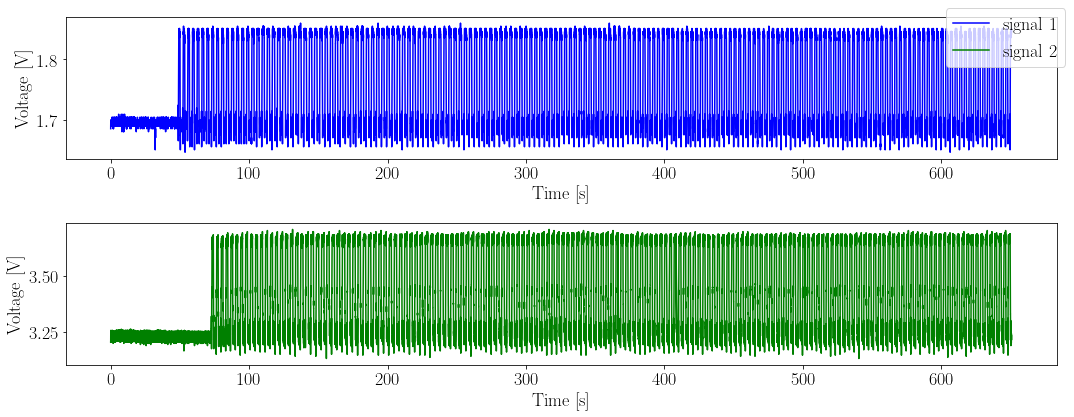

In [4]:
#************************************
folder   = '../../../T-data/2-12/'
filename = 'B-ol5-aq5-pause10.csv'

fol_name = folder.rstrip('/').rsplit('/', 1)[1]

name     = fol_name + '_' + filename.rsplit('-',1)[0]
print(f'{name = }')
#************************************

raw = True 
sig1, sig2, t_raw = ddt.read_LV(folder, filename)

## Resample data

data already resampled


<IPython.core.display.Javascript object>


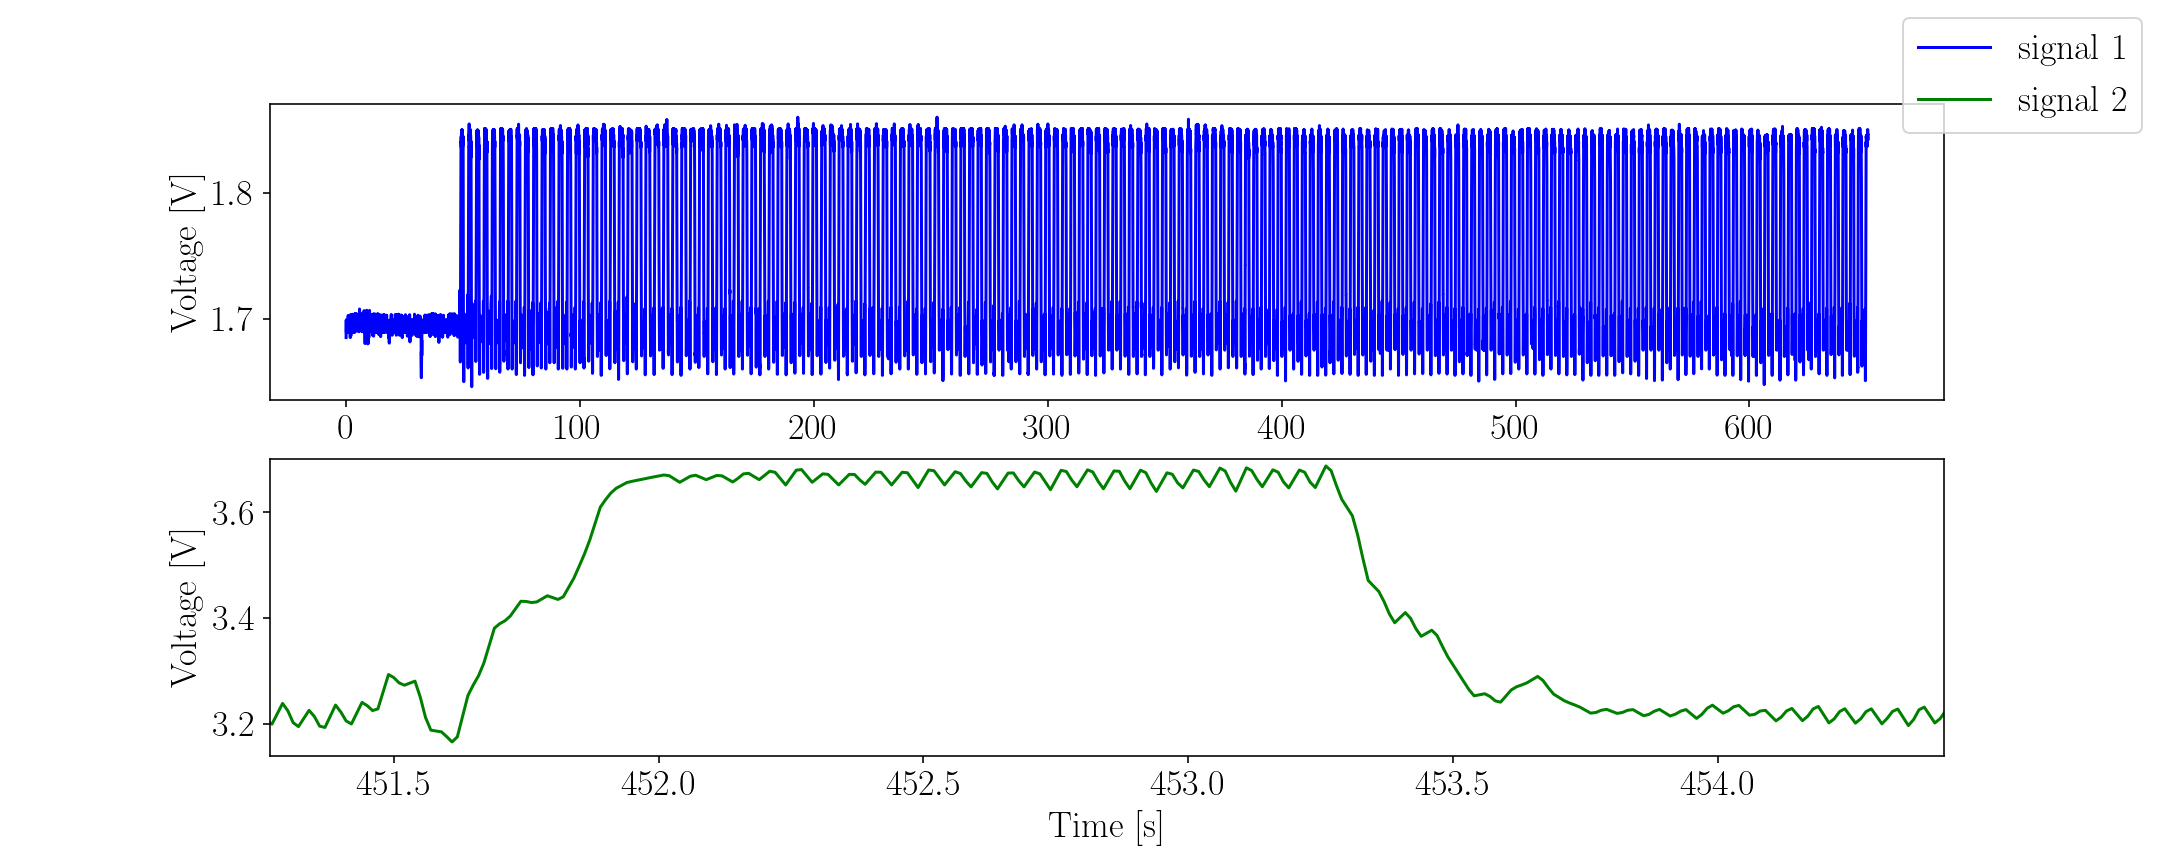

<ipython-input-18-2c55b89d88de>:22: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best')


In [18]:
#******************************
dt = 0.01  # sampling time [s]
#******************************

# Resampling of the two signals
if raw:
    sig1, new_t = ddt.resample(sig1, t_raw, dt=dt)
    sig2, _     = ddt.resample(sig2, t_raw, dt=dt)
    t           = new_t
    raw         = False 
else:
    print('data already resampled')

    
# Signals plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
axs[0].plot(t, sig1, color='blue', label= "signal 1")
axs[0].set_ylabel('Voltage [V]')
axs[1].plot(t, sig2, color='green', label= "signal 2")
axs[1].set_ylabel('Voltage [V]')
axs[1].set_xlabel('Time [s]')
fig.legend(loc='best')

## Fourier transform


In [6]:
min_freq  = 1       # lower cut-off frequency
max_freq  = 5000   # higher cut-off frequency

### Signal 1 

/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
../Library/drop_detection_tools.py:291: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  legend = fig.legend(['original signal','cropped signal'], loc='best')


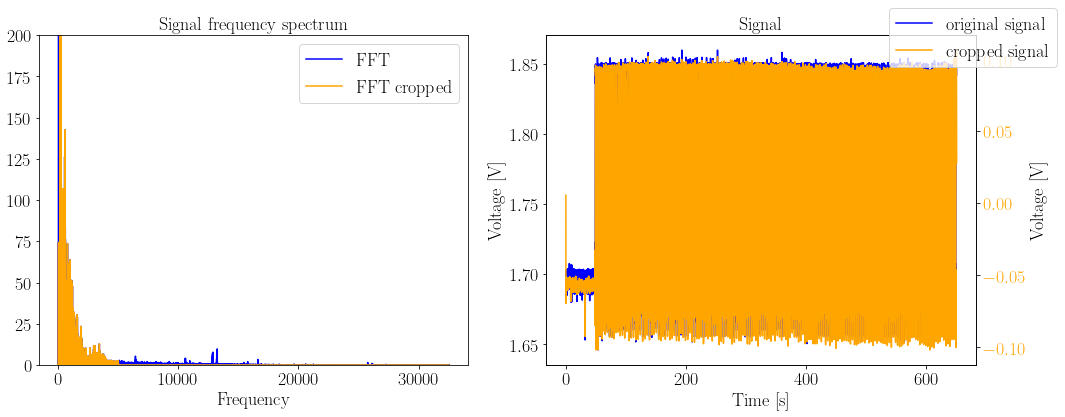

In [7]:
sig1_high = ddt.FFT_cropping(sig1, t, min_freq, max_freq)

### Signal 2 

/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
../Library/drop_detection_tools.py:291: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  legend = fig.legend(['original signal','cropped signal'], loc='best')


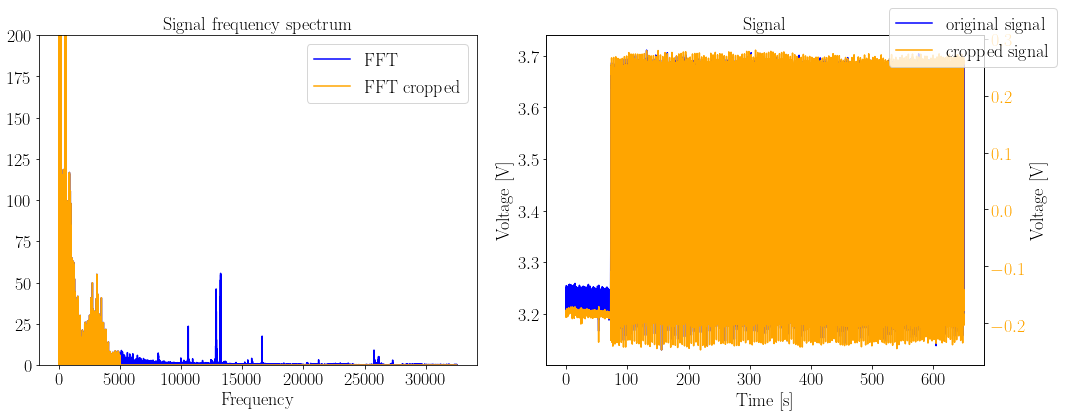

In [8]:
sig2_high = ddt.FFT_cropping(sig2, t, min_freq, max_freq)

## Signal Rectify

### Signal 1 

In [69]:
sig1_r = sig1_high
sig2_r = sig2_high

100%|██████████| 65068/65068 [00:05<00:00, 11380.04it/s]


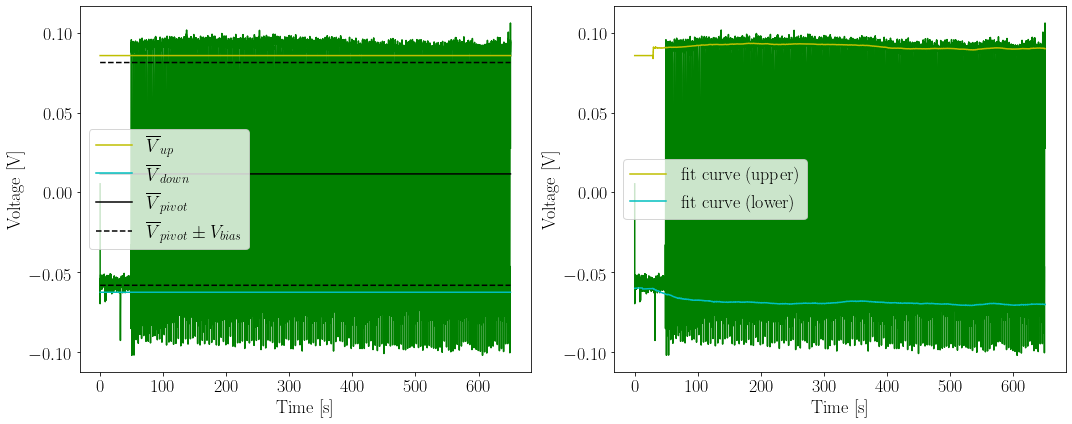

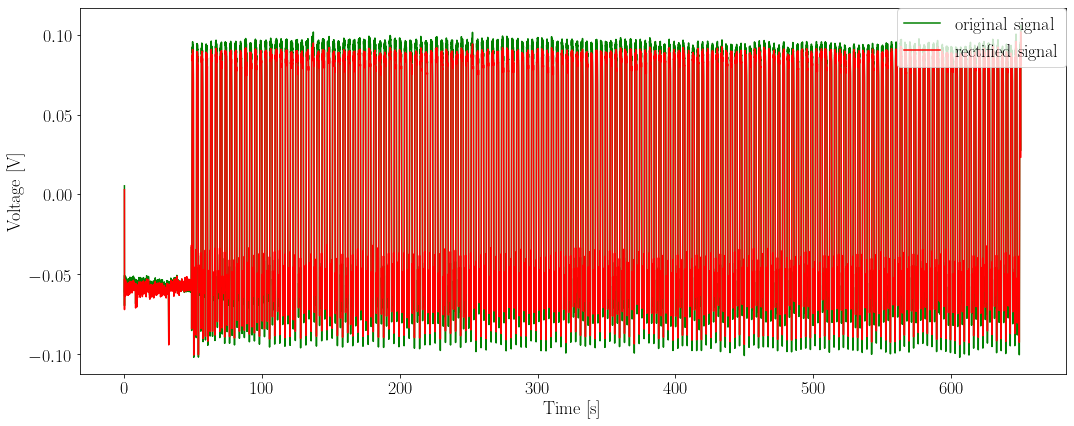

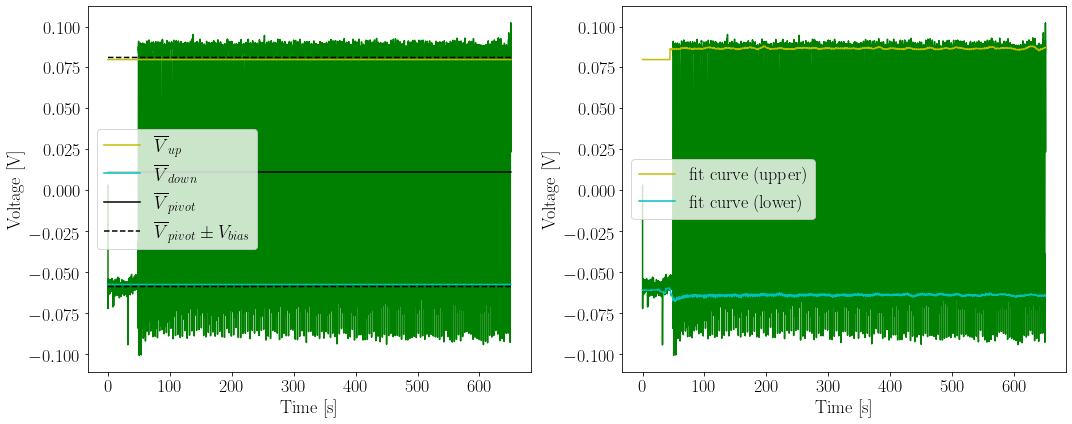

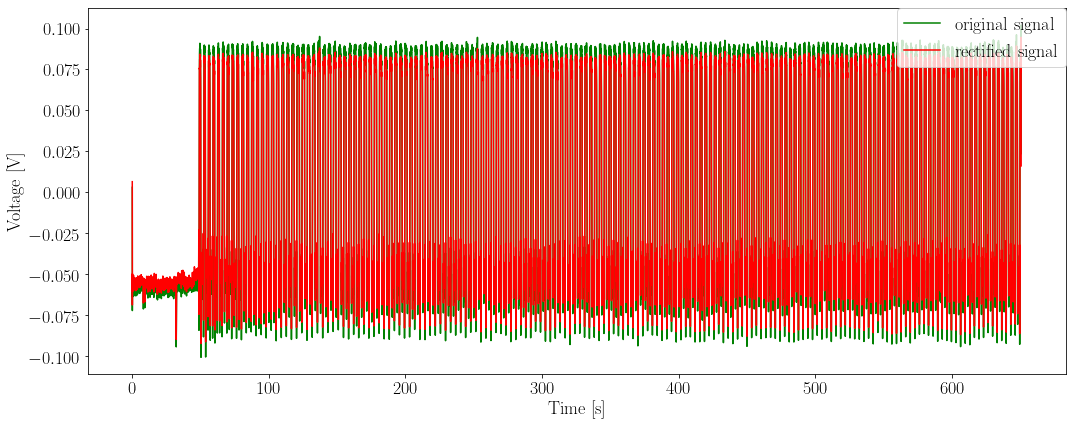

In [9]:
%matplotlib inline

fig, sig1_r = ddt.rectify_new(sig1_high, xrange=20, xdata=t, ignore_bias=0.07, manual_thr=-0.13)

fig, sig1_r = ddt.rectify_new(sig1_r, xrange=5, xdata=t, ignore_bias=0.07, manual_thr=-0.13)

### Signal 2

100%|██████████| 65068/65068 [00:05<00:00, 11376.25it/s]


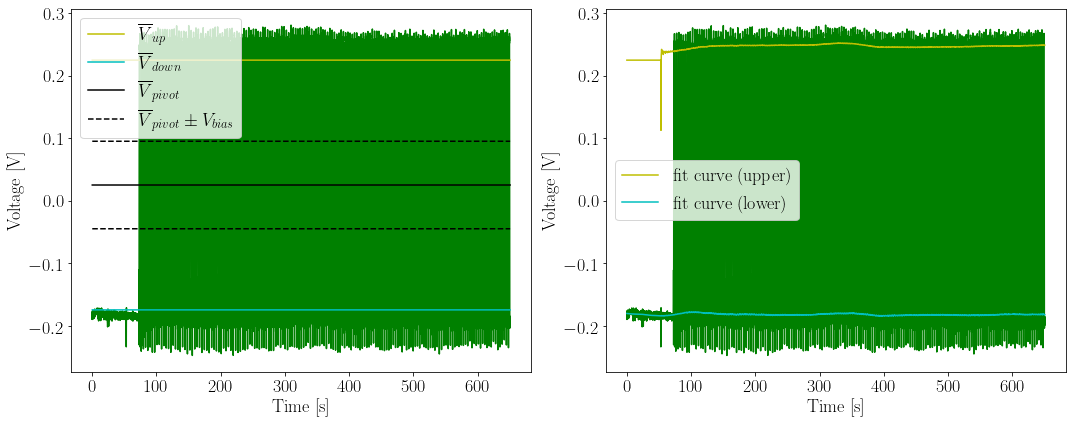

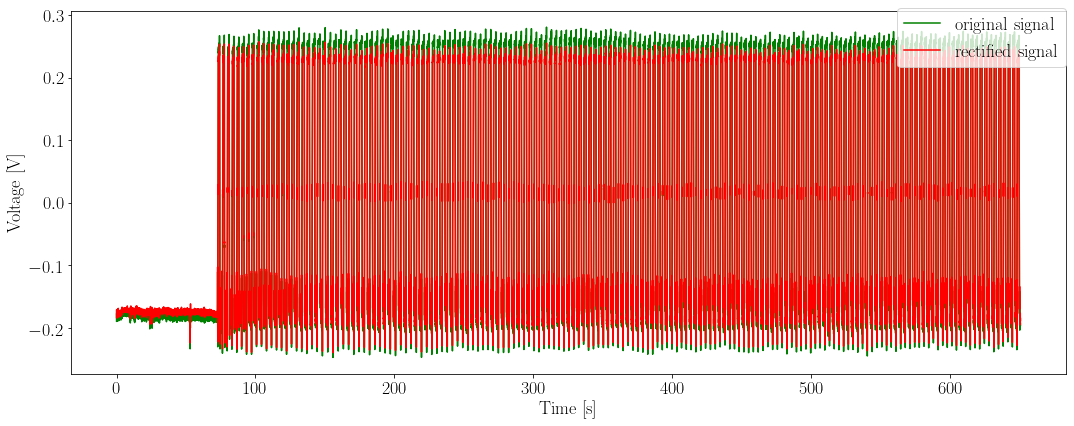

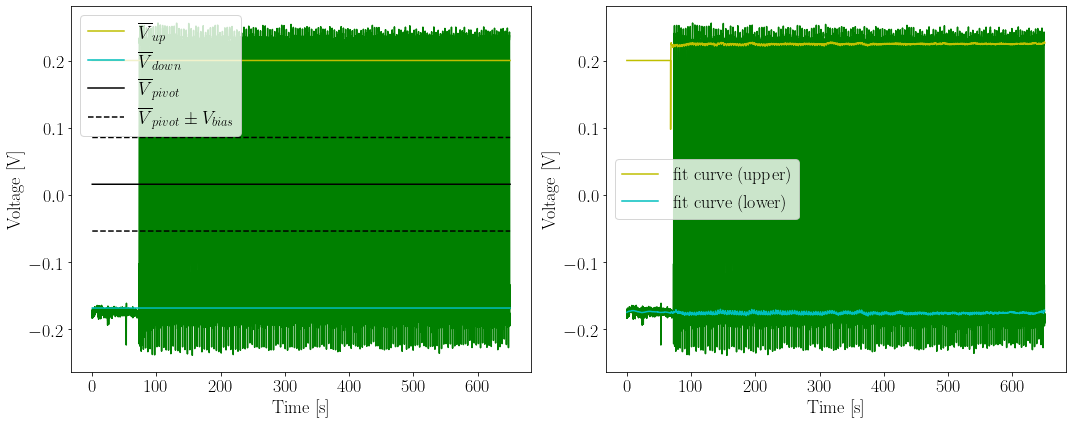

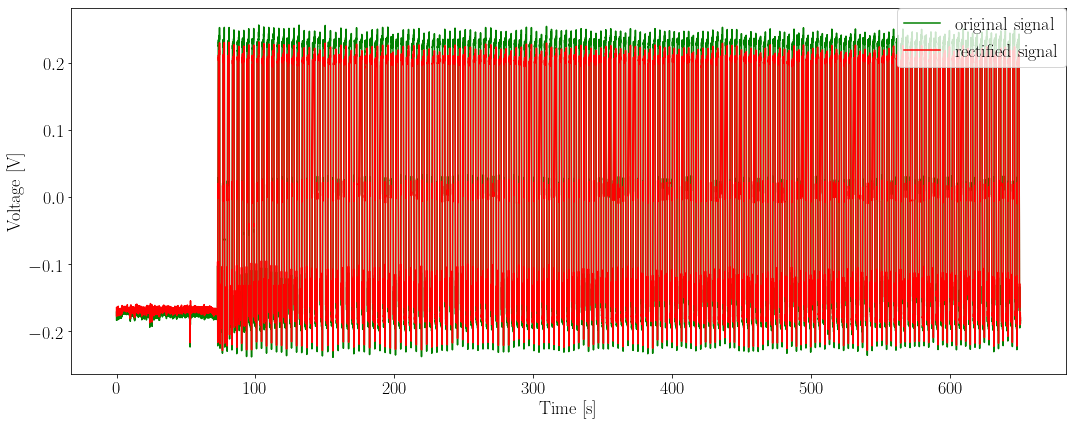

In [10]:
fig, sig2_r = ddt.rectify_new(sig2_high, xrange=20, xdata=t, ignore_bias=0.07, manual_thr=-0.32)

fig, sig2_r = ddt.rectify_new(sig2_r, xrange=5, xdata=t, ignore_bias=0.07, manual_thr=-0.32)

## Thresholds computing

### Signal 1

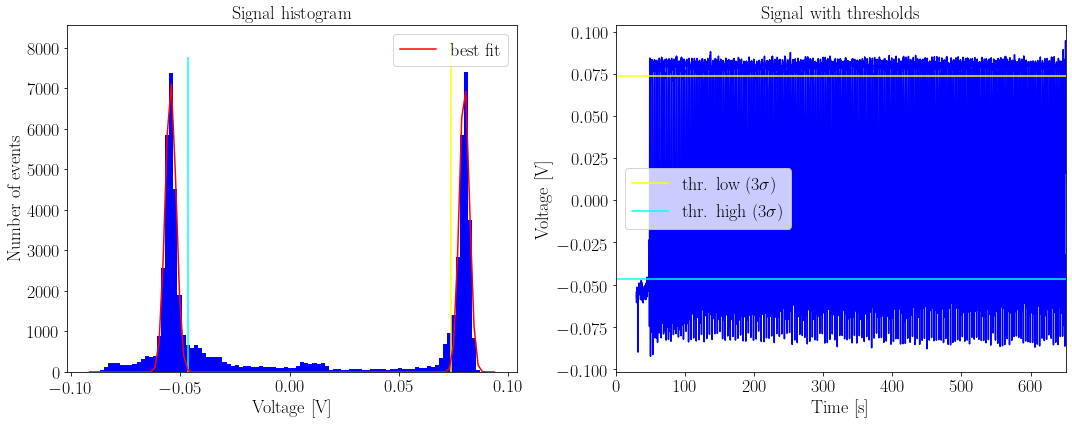

In [11]:
# %matplotlib notebook
# %matplotlib notebook
thr_low_1, thr_high_1, sigma_low_1, sigma_high_1 = ddt.thr_searcher(sig1_r[3000:], 100,
                                         high_sigmas=3, low_sigmas=3, Xdata=t[3000:],
                                         color='blue', xlabel='Time [s]', ylabel='Voltage [V]')

### Signal 2

<IPython.core.display.Javascript object>


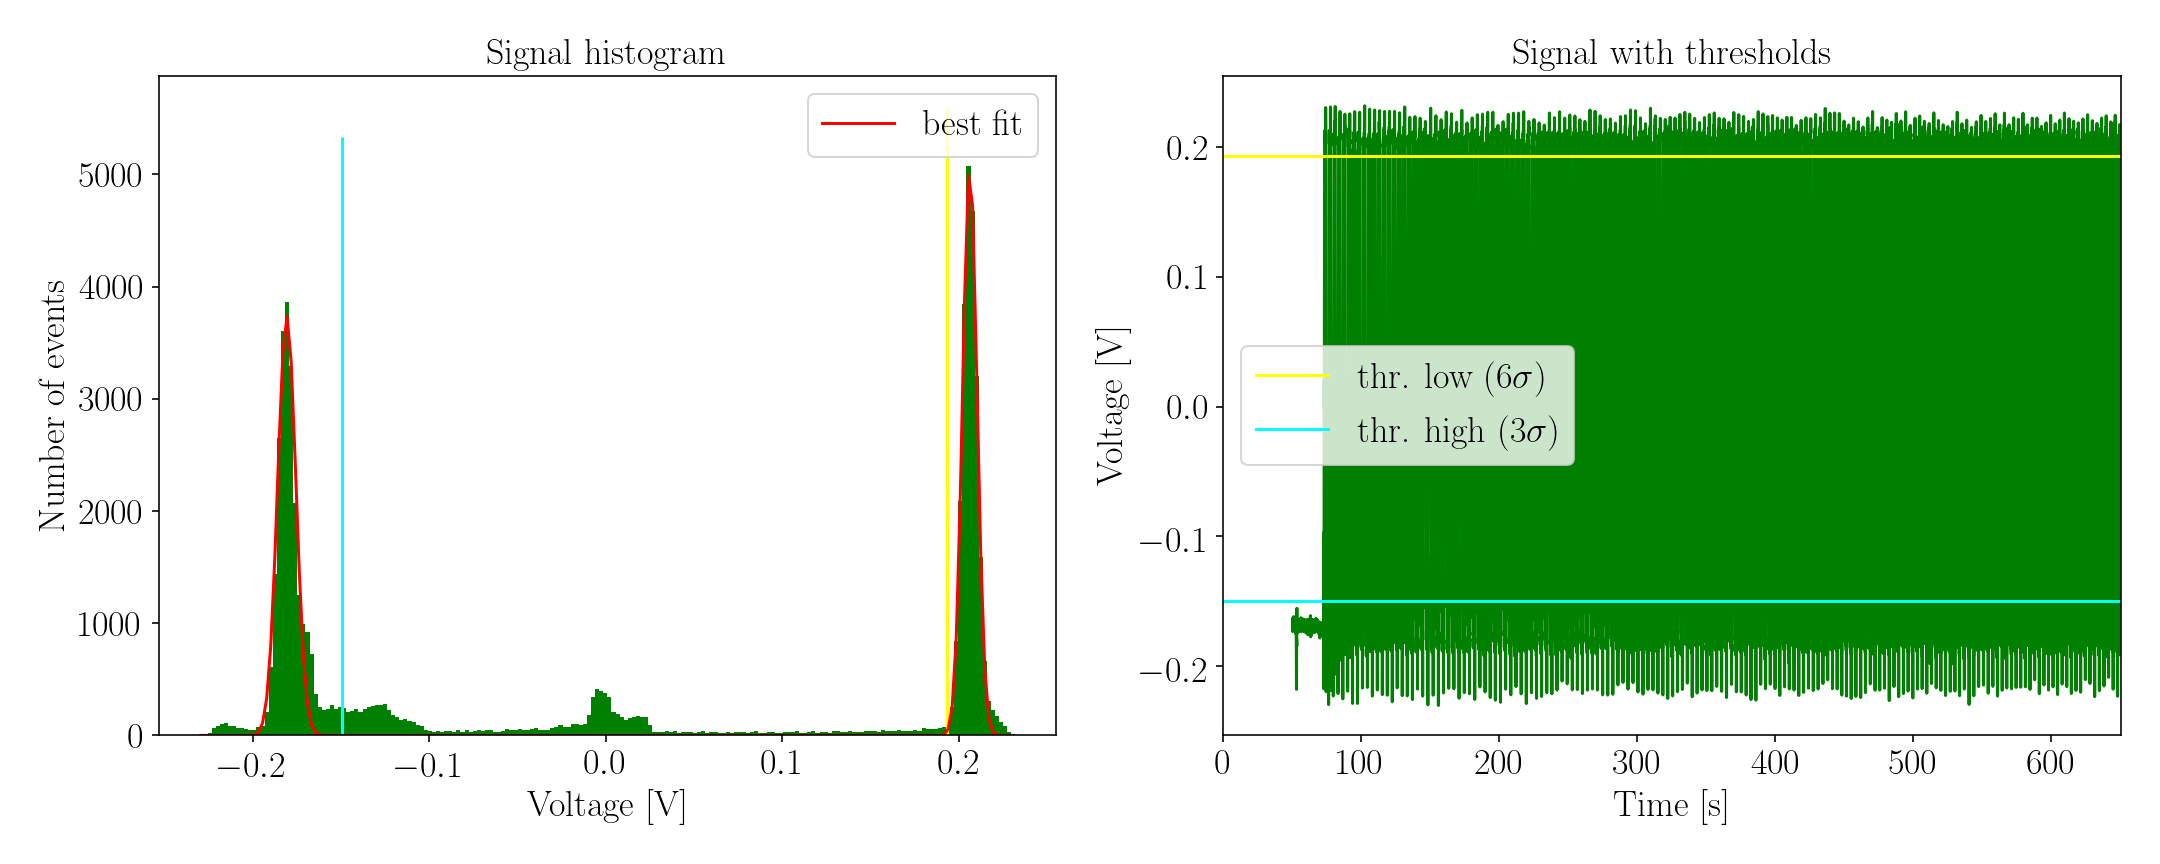

In [13]:
# %matplotlib notebook
%matplotlib notebook
thr_low_2, thr_high_2, sigma_low_2, sigma_high_2 = ddt.thr_searcher(sig2_r[5000:], 200, low_sigmas=6, high_sigmas=3, Xdata=t[5000:],
                                         color='green', xlabel='Time [s]', ylabel='Voltage [V]')

## Drops detection

### Signal 1

In [81]:
reload(ddt)

<module 'drop_detection_tools' from '../Library/drop_detection_tools.py'>

171 171
650.63 s: Couldn't find wide end, inserting a fake one
171 171


<IPython.core.display.Javascript object>


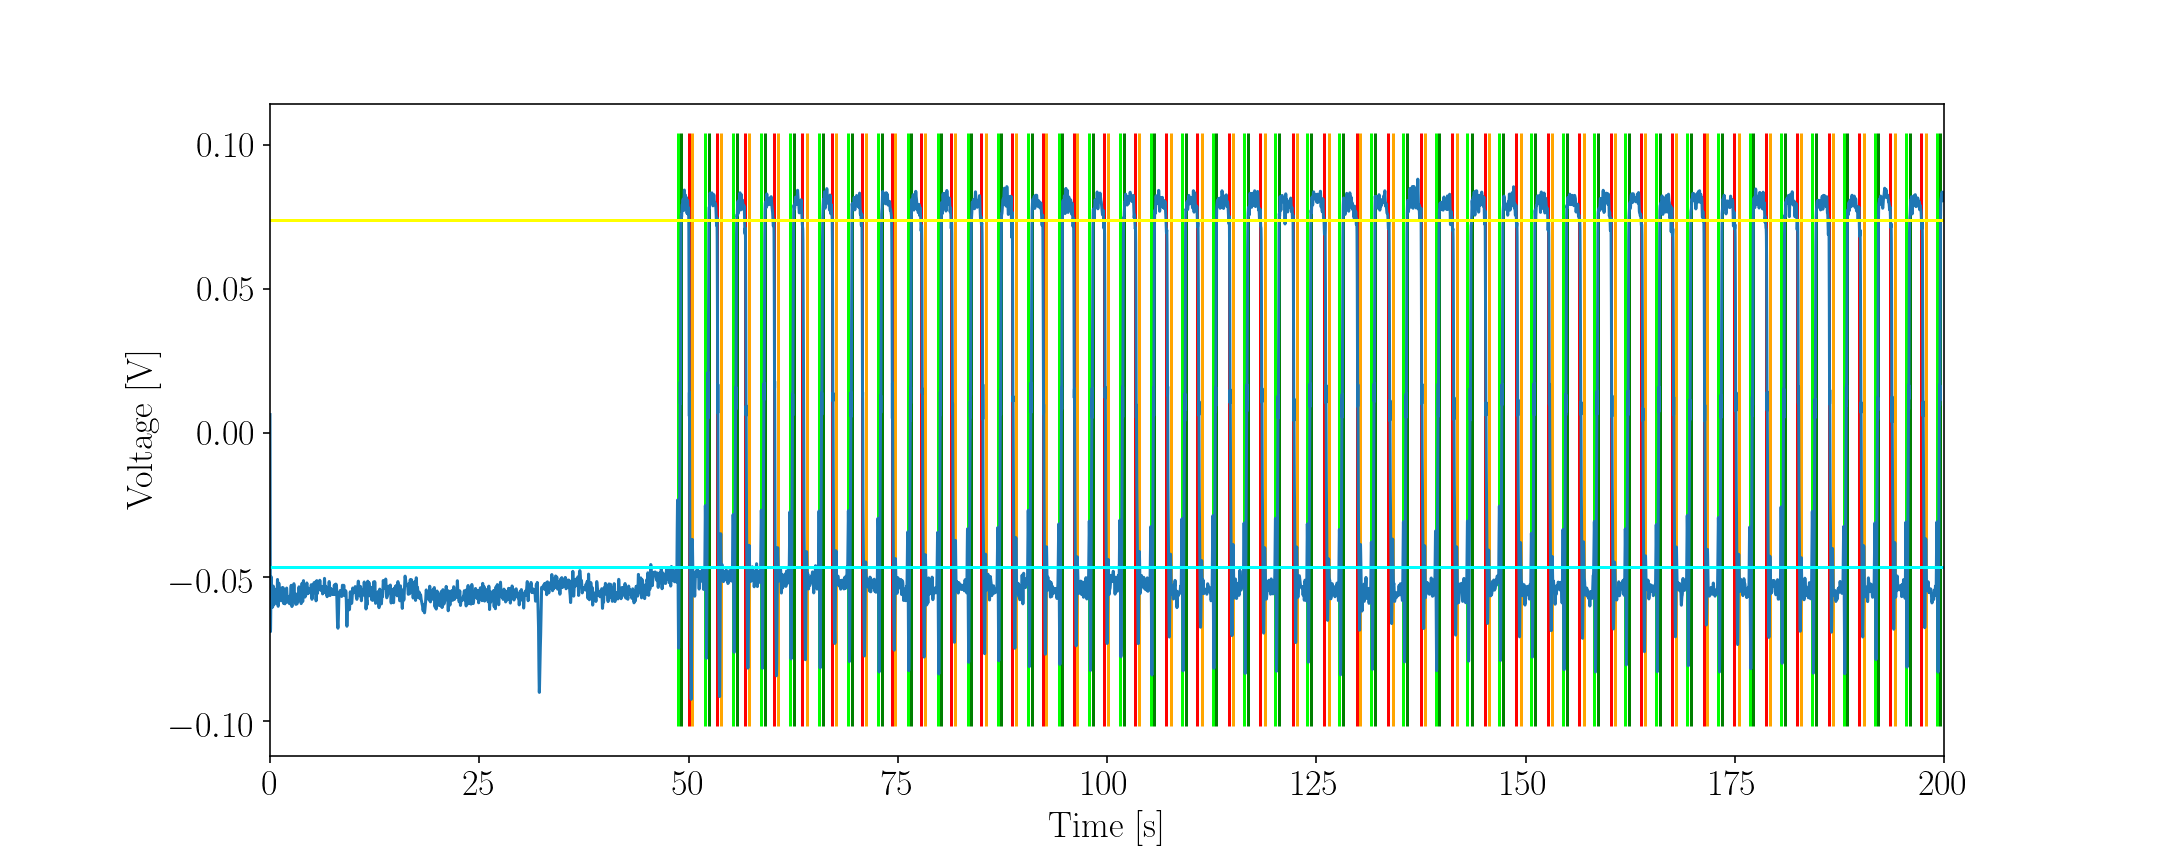

<IPython.core.display.Javascript object>


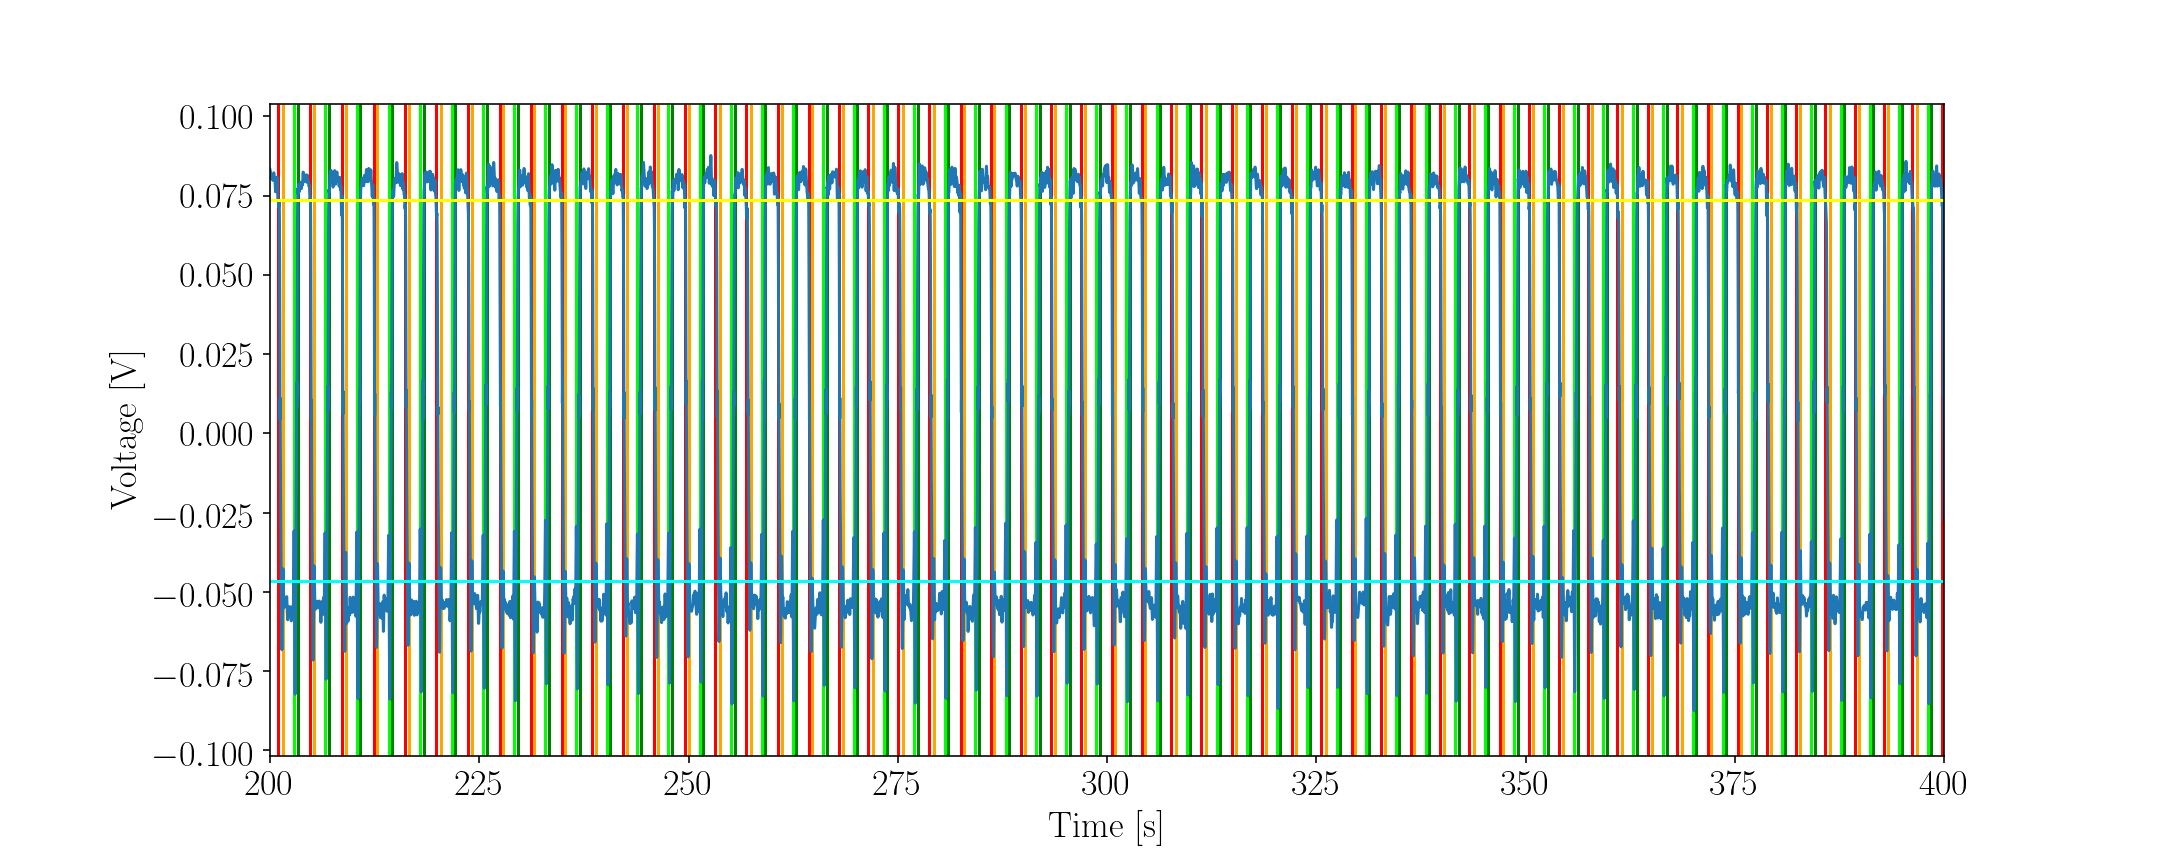

<IPython.core.display.Javascript object>


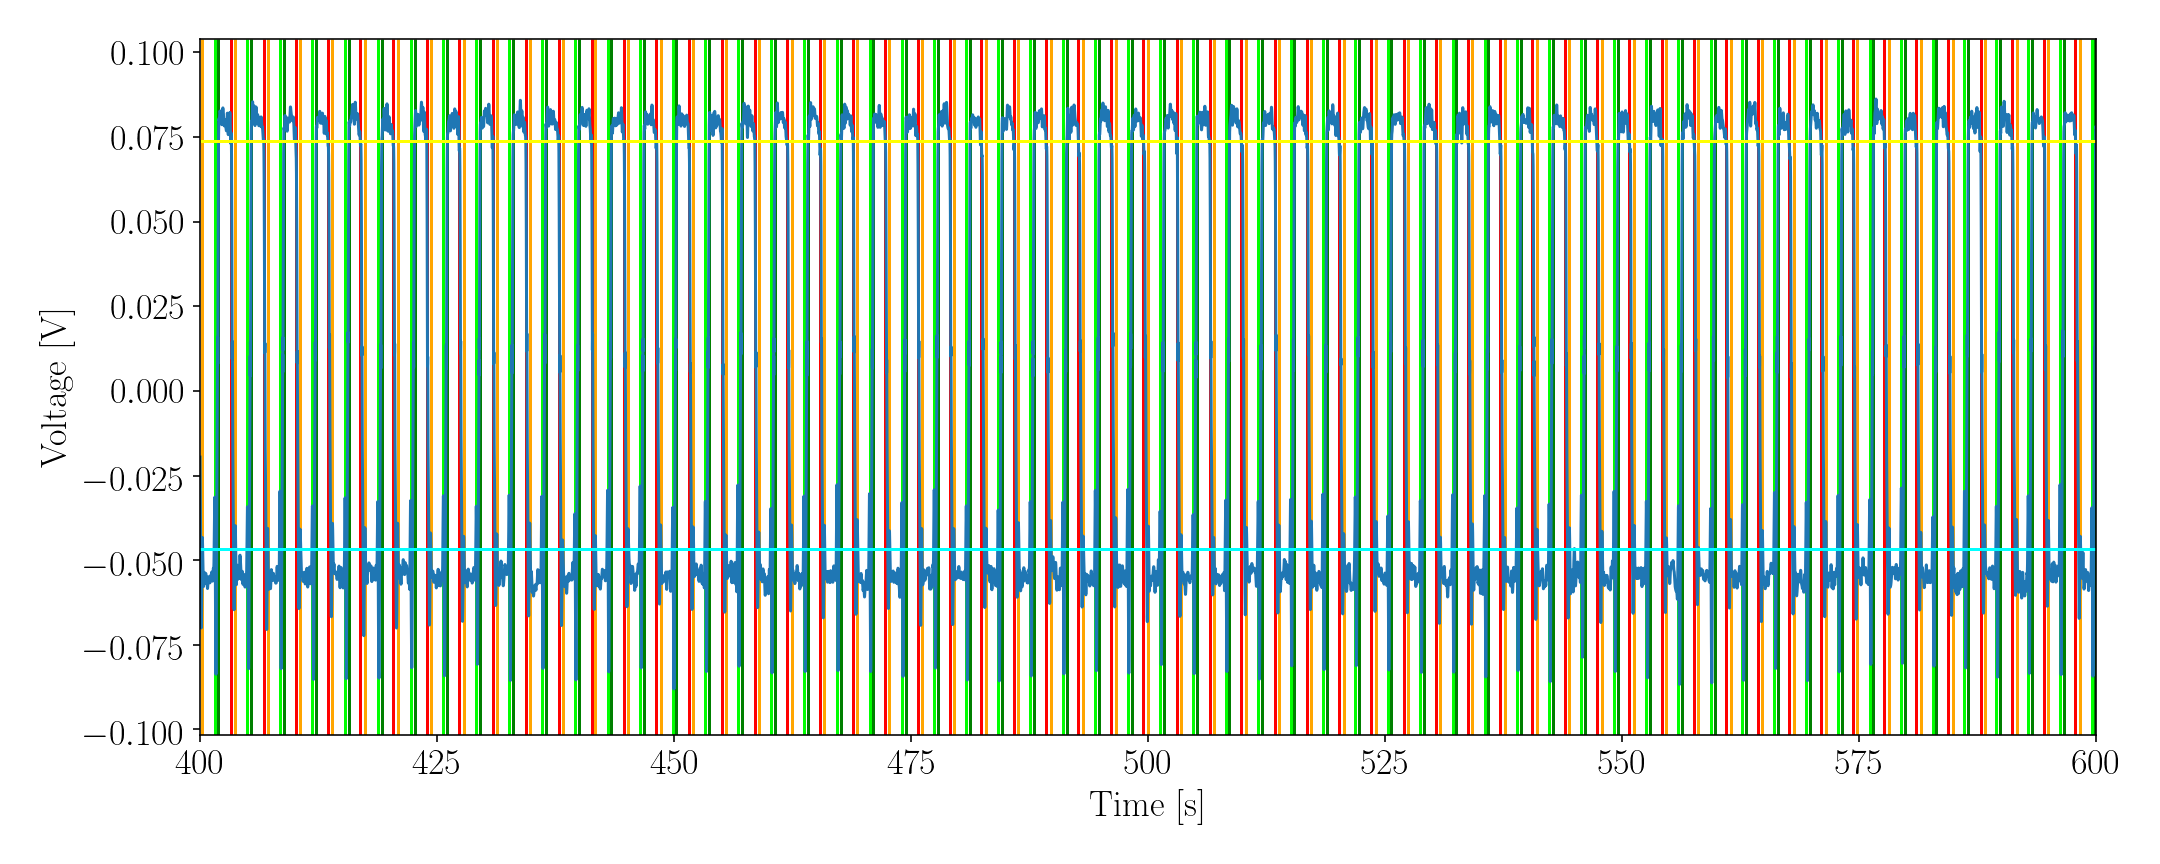

In [90]:
#****************************************
xrange = 200 # single plot x range [s]
#****************************************
reload(ddt)
%matplotlib notebook
%matplotlib notebook

returns = ddt.drop_det_new(t, sig1_r, thr_low_1, thr_high_1, backward_skip=1, forward_skip=1, return_indexes=True,
                       xrange=xrange, plot_switch=True, xlabel="Time [s]", ylabel="Voltage [V]")

narrow_start_1, narrow_end_1, wide_start_1, wide_end_1 = returns
#function modified to give output arrays in index form, not in seconds.

drop_edges_1 = np.array(list(zip(wide_start_1, narrow_start_1, narrow_end_1, wide_end_1)))


#### Manually correct the position of the edges

<IPython.core.display.Javascript object>


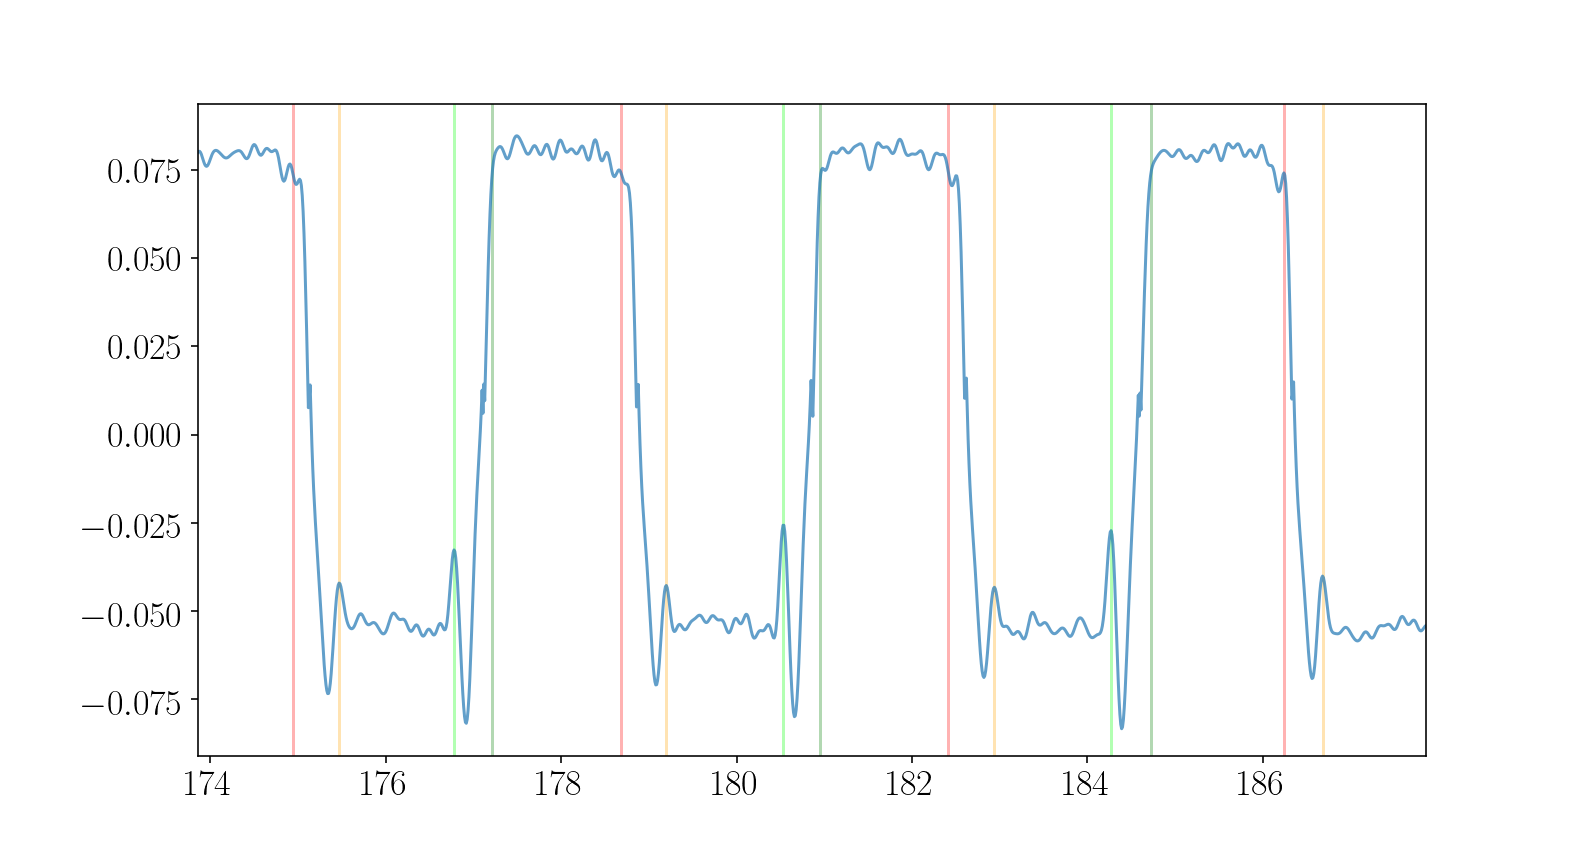

In [91]:
dec1 = ddt.DropEdgeCorrector(drop_edges_1)
dec1(t,sig1_r, figsize=(11,6))

In [92]:
drop_edges_1 = dec1.drop_edges

wide_start_1, narrow_start_1, narrow_end_1, wide_end_1 = drop_edges_1.T

### Signal 2

164 164
482.91 s: Missed previous wide end: trying to adjust
530.53 s: Missed previous wide end: trying to adjust
574.86 s: Missed previous wide end: trying to adjust
591.7 s: Missed previous wide end: trying to adjust
614.9300000000001 s: Missed previous wide end: trying to adjust
164 164


<IPython.core.display.Javascript object>


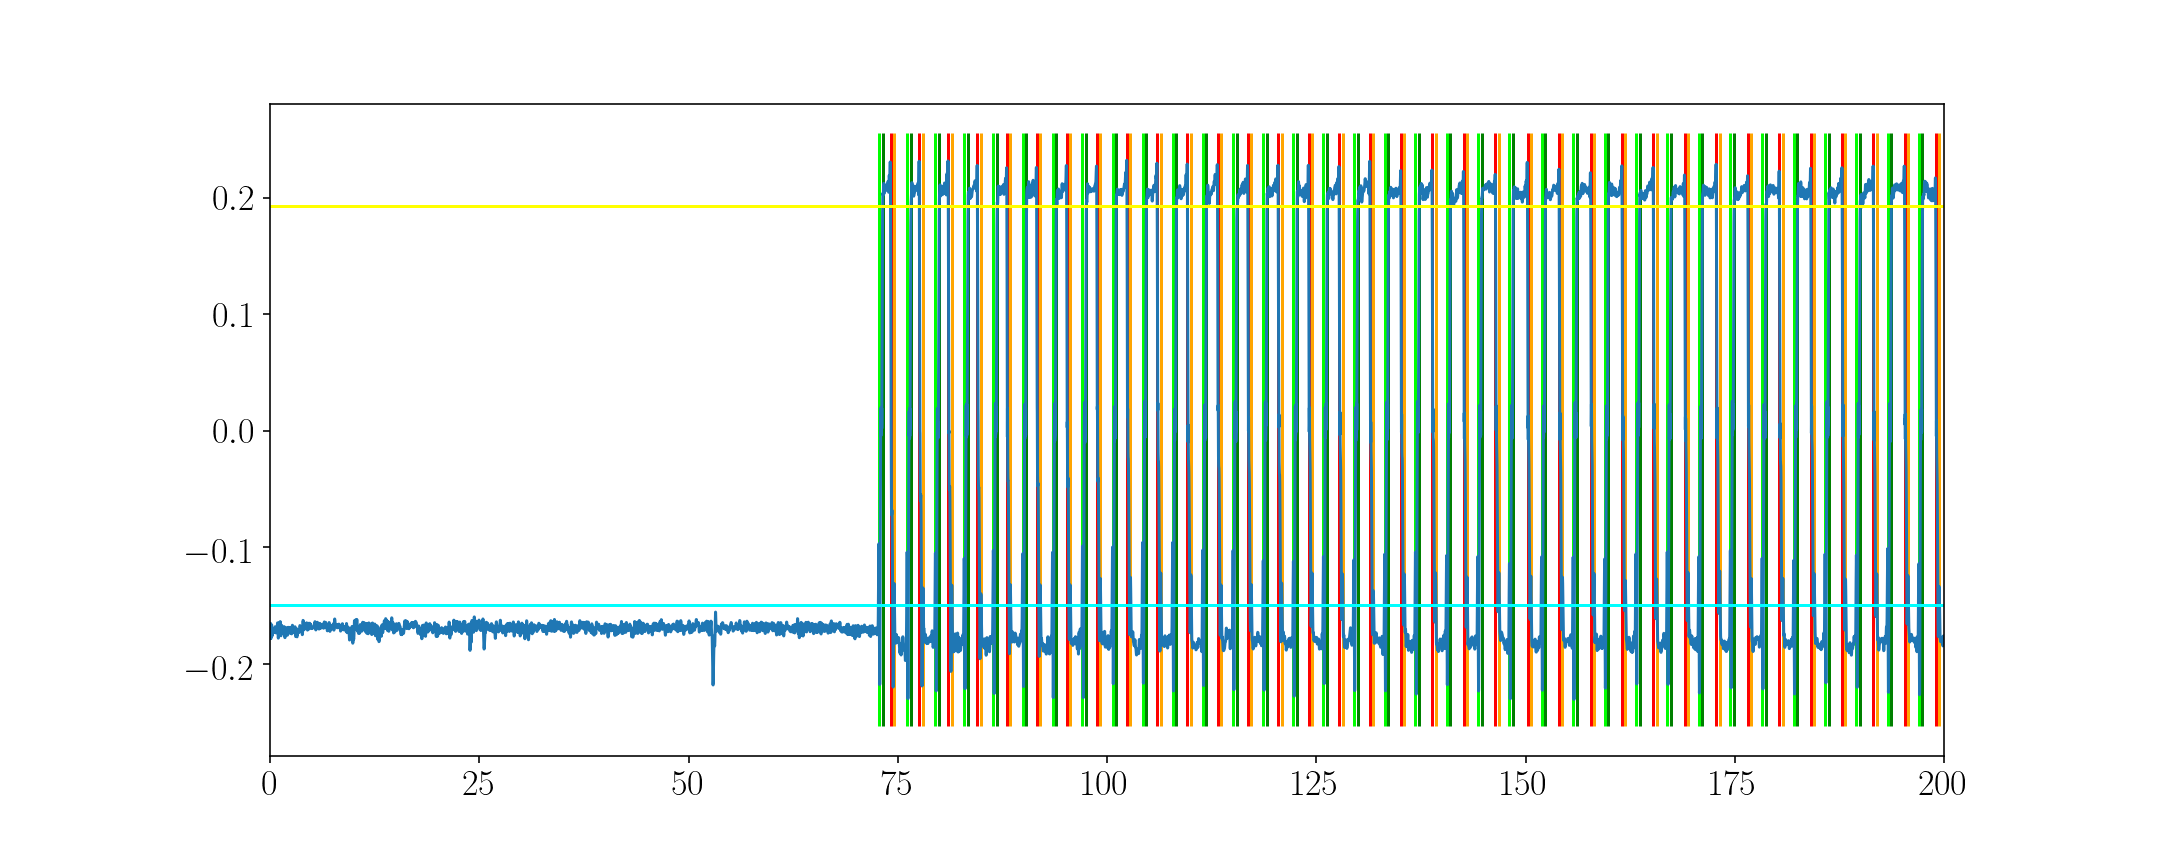

<IPython.core.display.Javascript object>


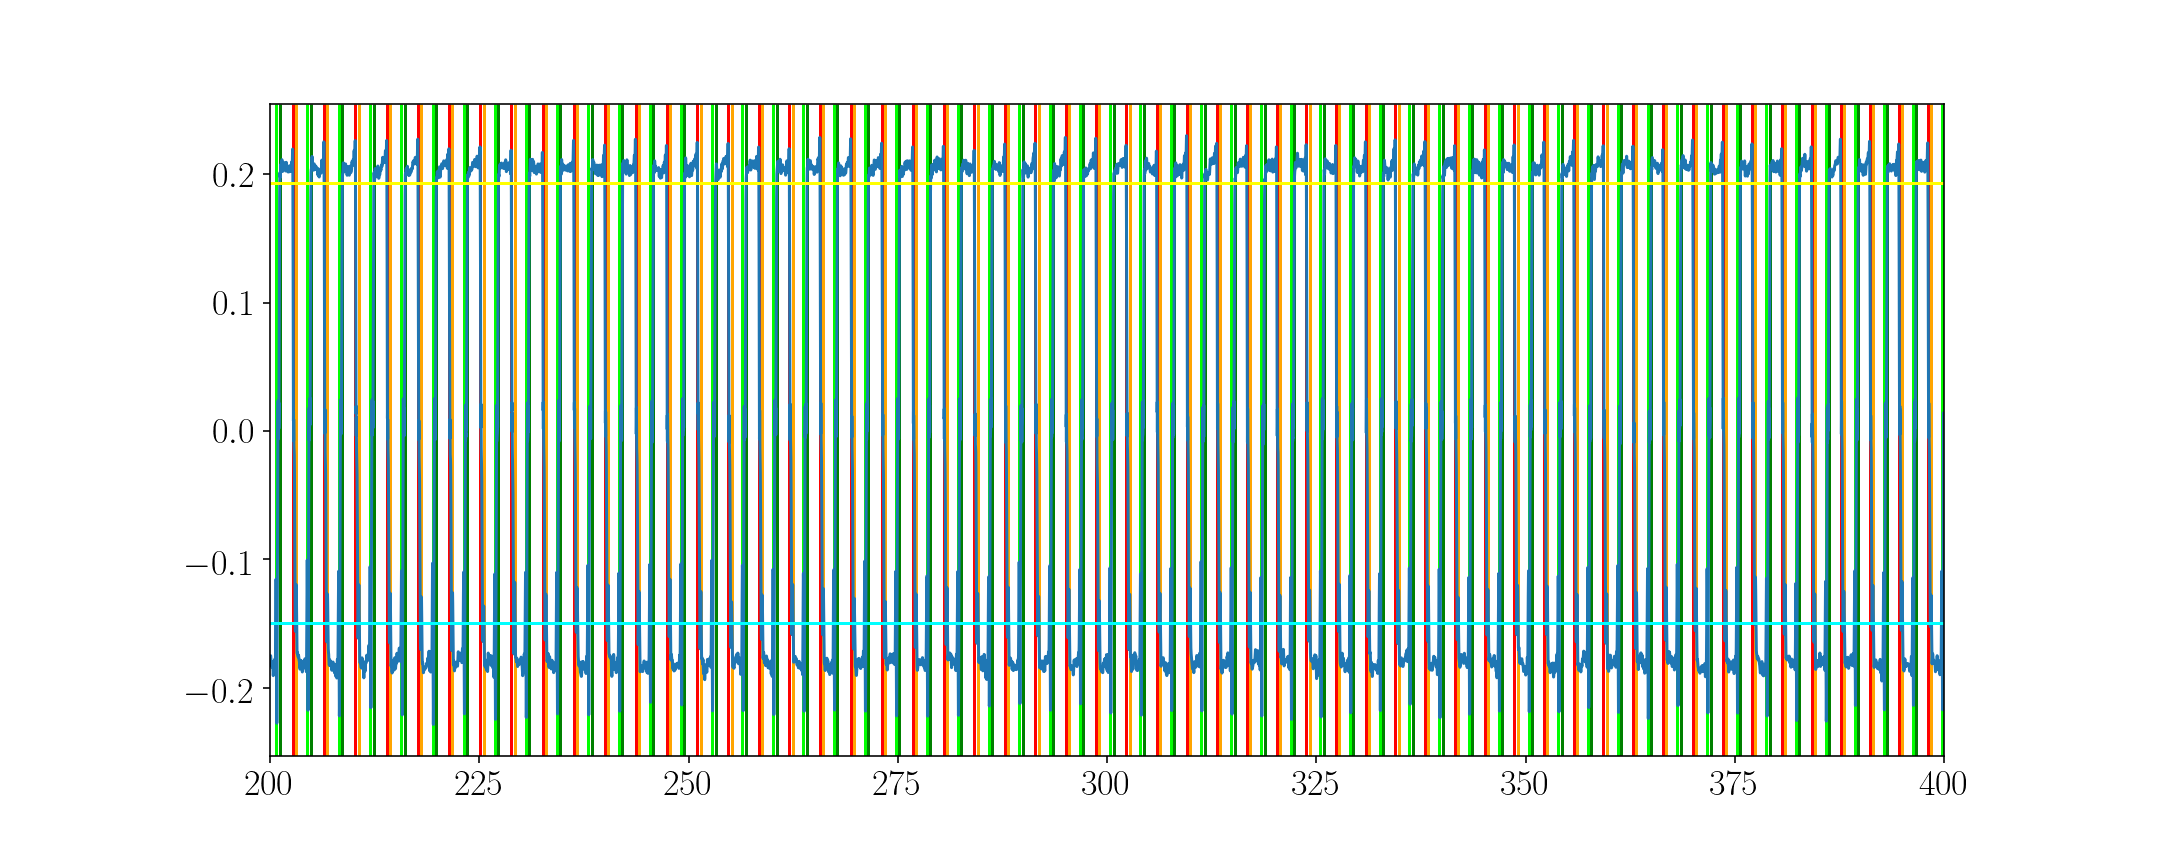

<IPython.core.display.Javascript object>


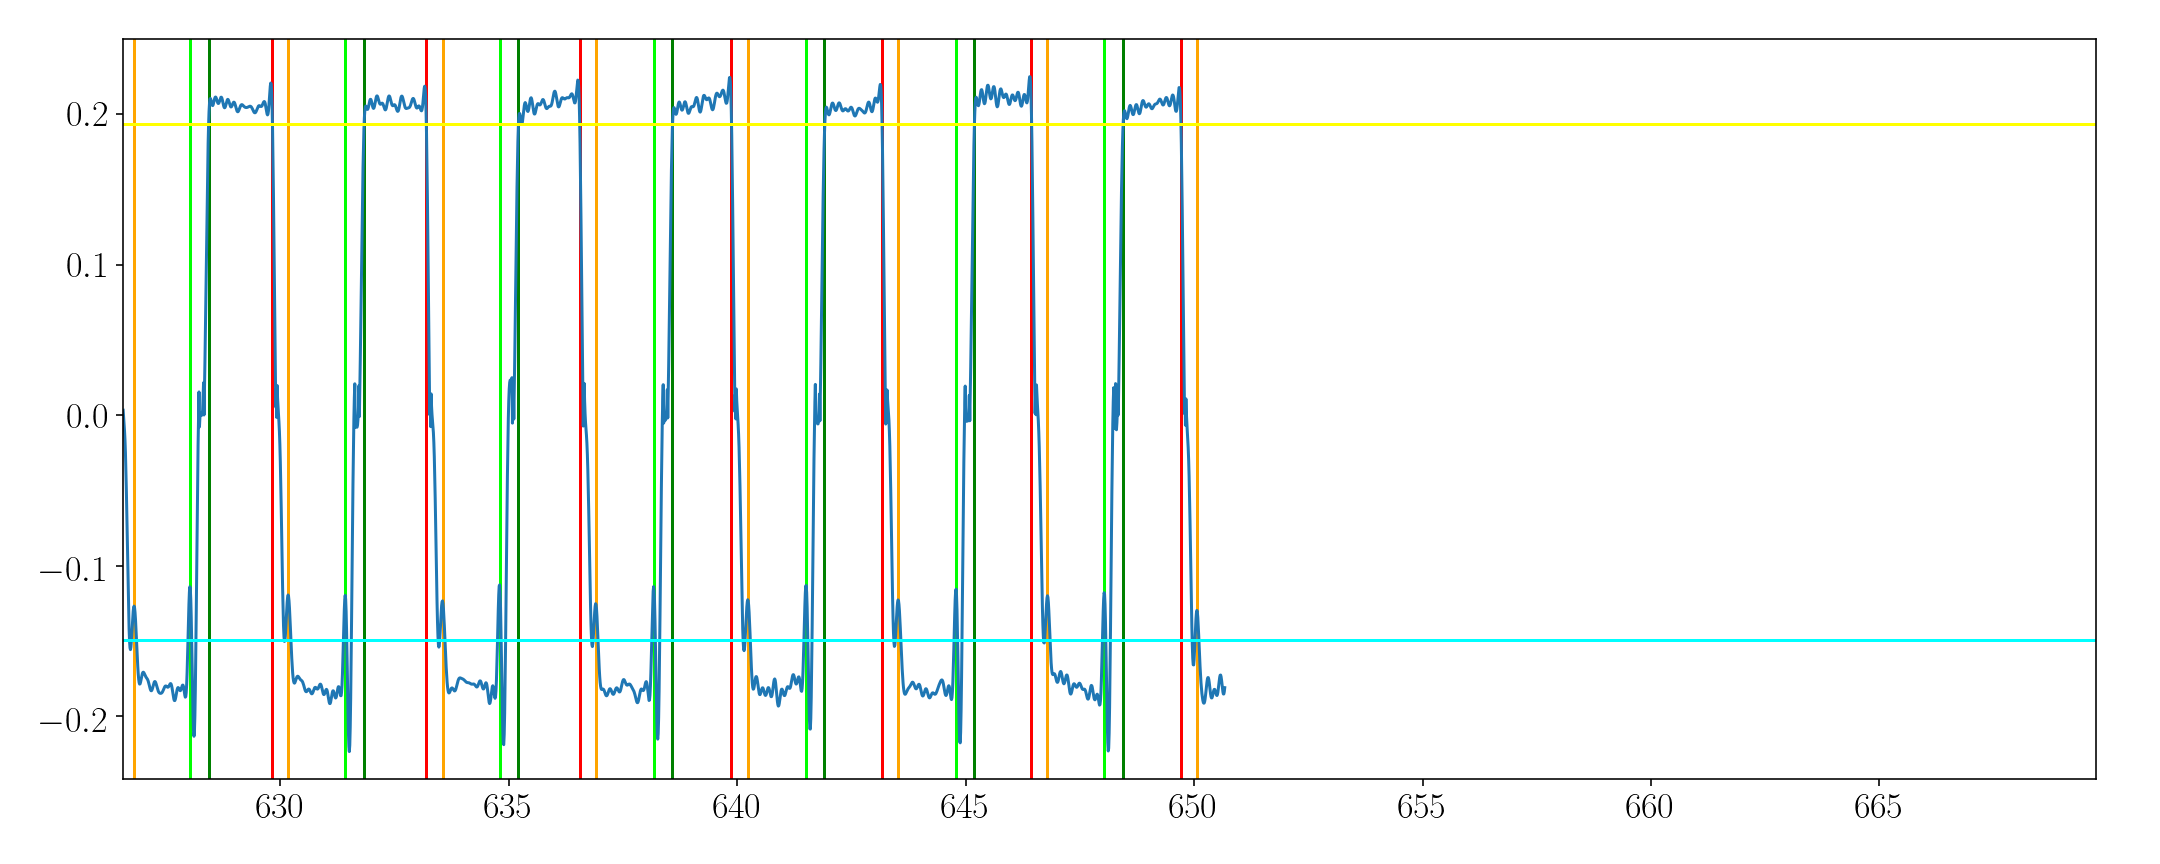

In [17]:
#****************************************
xrange = 200 # single plot x range [s]
#****************************************

%matplotlib notebook
returns = ddt.drop_det_new(t, sig2_r, thr_low_2, thr_high_2, backward_skip=1, forward_skip=1, return_indexes=True,
                       xrange=xrange, plot_switch=True)

narrow_start_2, narrow_end_2, wide_start_2, wide_end_2 = returns
#function modified to give output arrays in index form, not in seconds.

drop_edges_2 = np.array(list(zip(wide_start_2, narrow_start_2, narrow_end_2, wide_end_2)))


In [ ]:
dec2 = ddt.DropEdgeCorrector(drop_edges_2)
dec2(t,sig2_r, figsize=(11,6))

In [ ]:
drop_edges_2 = dec1.drop_edges

wide_start_2, narrow_start_2, narrow_end_2, wide_end_2 = drop_edges_2.T

## Add errors

<IPython.core.display.Javascript object>


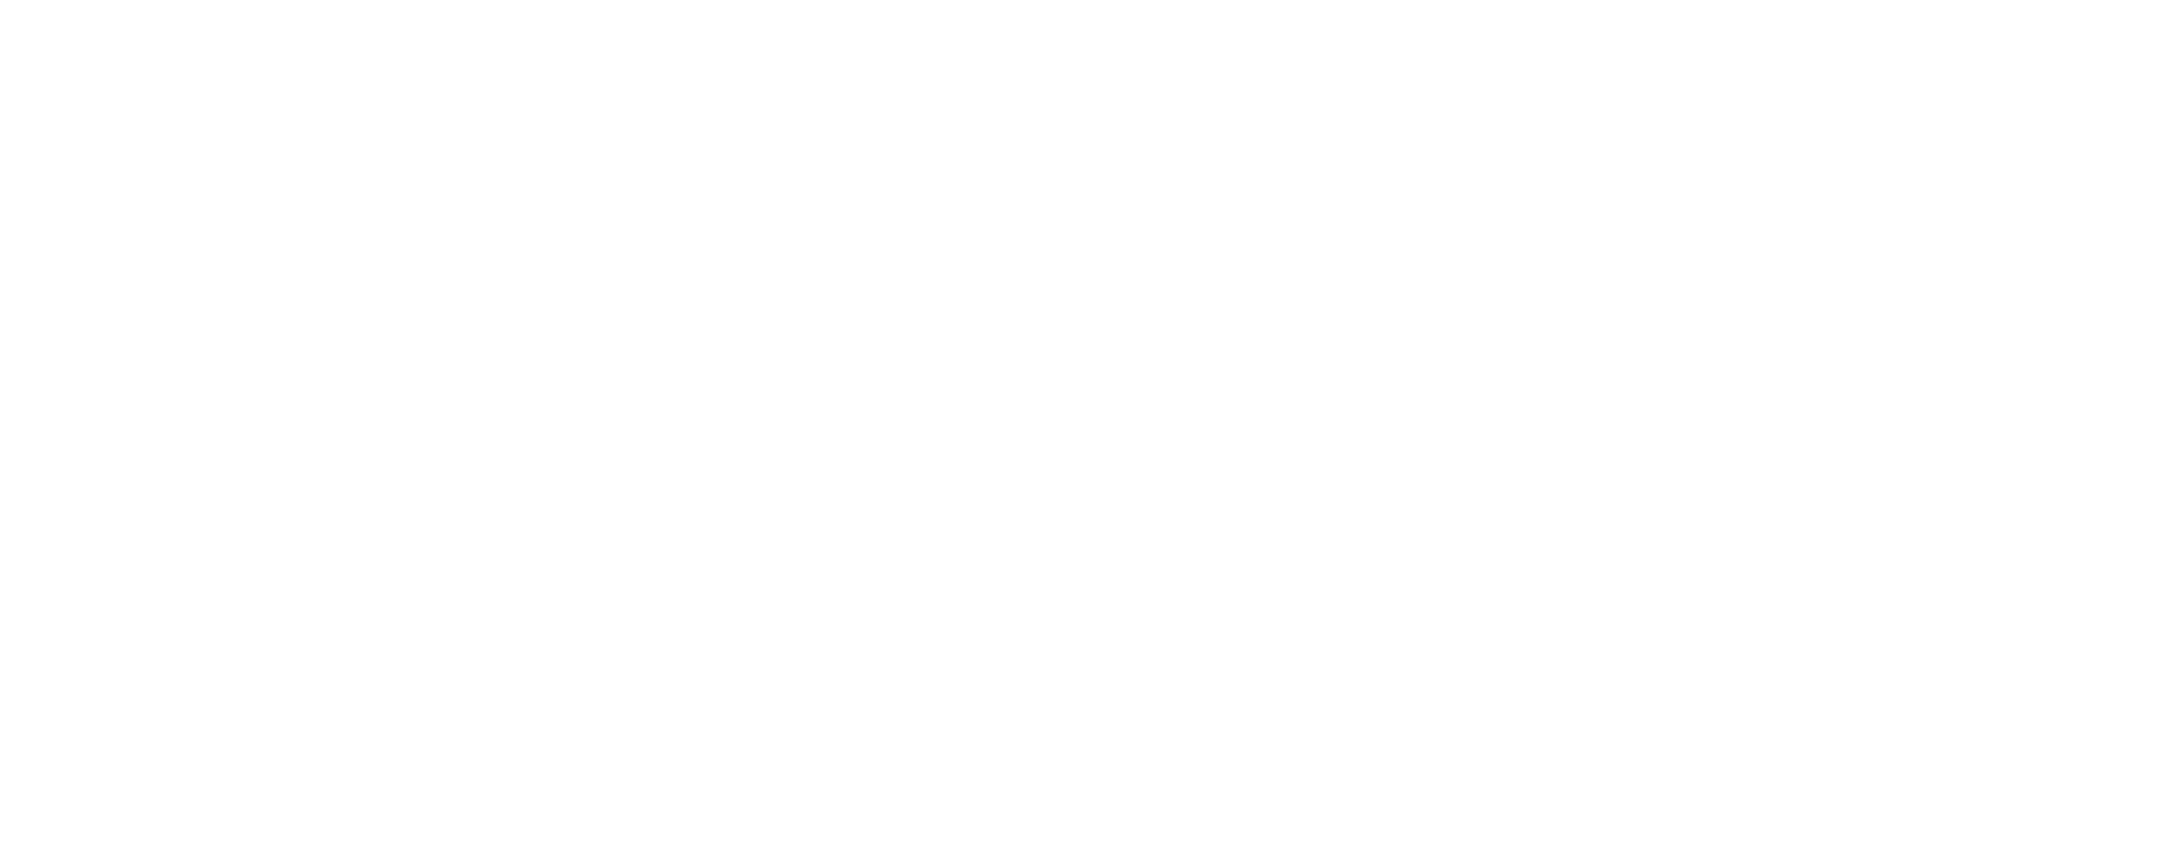

In [16]:
%matplotlib notebook
%matplotlib notebook
slope_start_1, slope_end_1=ddt.slopes(t,sig1_r, narrow_start_1, narrow_end_1, start_range=3, end_range = 5, xlabel="Time [s]", ylabel="Voltage [V]")

<IPython.core.display.Javascript object>


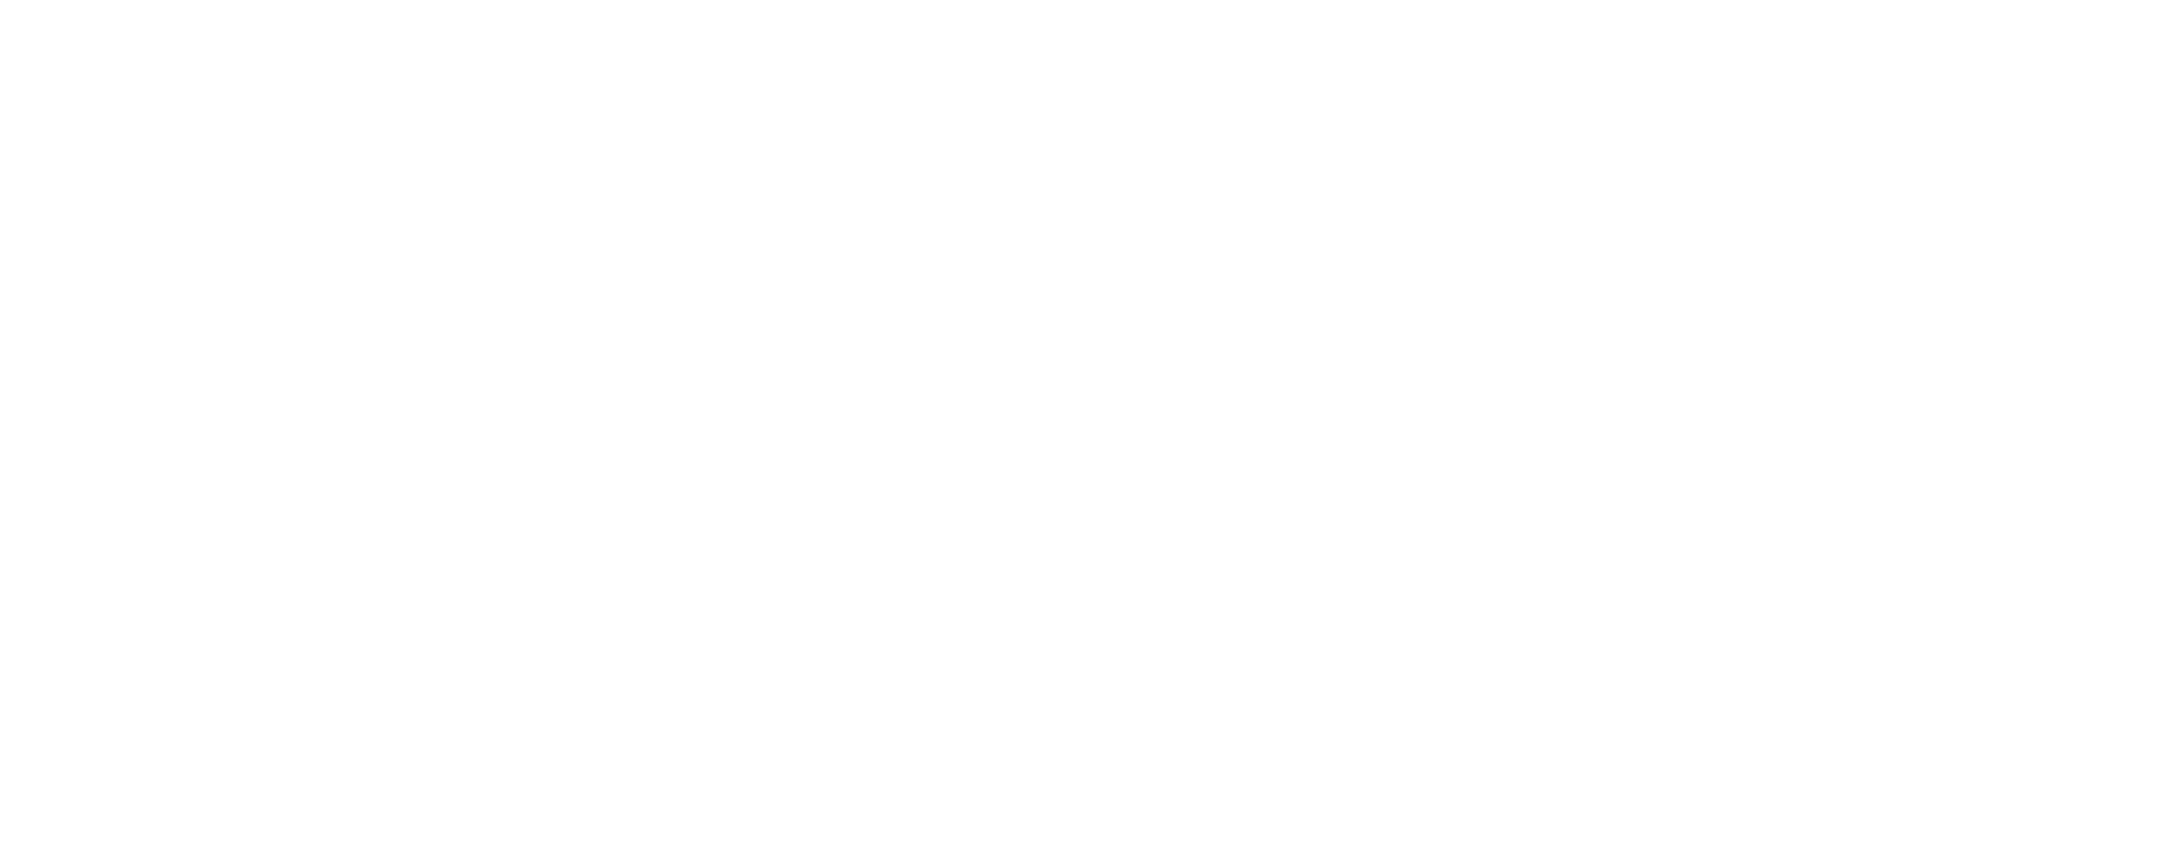

In [17]:
slope_start_2, slope_end_2=ddt.slopes(t,sig2_r, narrow_start_2, narrow_end_2, start_range=3, end_range = 5, xlabel="Time [s]", ylabel="Voltage [V]")

In [18]:
#slope errors for narrow_start and narrow_end
v_err_1 = sigma_high_1
err_slope_start_1 = v_err_1/slope_start_1
err_slope_end_1 = -v_err_1/slope_end_1

v_err_2 = sigma_high_2
err_slope_start_2 = v_err_2/slope_start_2
err_slope_end_2 = -v_err_2/slope_end_2


In [19]:
def res_error(time):
    a = t_raw[np.where(t_raw >= time)]
    
    return (a[1] - a[0])/np.sqrt(12)
#     return a[1] - a[0]

### Make ufloats

In [20]:
#error resolution + error slope (seconds)
err_n_start_1=[]
err_n_end_1=[]
err_w_start_1=[]
err_w_end_1=[]
err_n_start_2=[]
err_n_end_2=[]
err_w_start_2=[]
err_w_end_2=[]

drop_edges_1 = [err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1]
drop_edges_2 = [err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2]

for drop_idx in range(len(narrow_start_1)):
    ens1 = (np.sqrt(res_error(t[narrow_start_1[drop_idx]])**2 + err_slope_start_1[drop_idx]**2))
    ene1 = (np.sqrt(res_error(t[narrow_end_1[drop_idx]])**2 + err_slope_end_1[drop_idx]**2))
    ews1 = (res_error(t[wide_start_1[drop_idx]]))
    ewe1 = (res_error(t[wide_end_1[drop_idx]]))
    
    err_n_start_1.append(unc.ufloat(t[narrow_start_1[drop_idx]],ens1))
    err_n_end_1.append(unc.ufloat(t[narrow_end_1[drop_idx]],ene1))
    err_w_start_1.append(unc.ufloat(t[wide_start_1[drop_idx]],ews1))
    err_w_end_1.append(unc.ufloat(t[wide_end_1[drop_idx]],ewe1))

for drop_idx in range(len(narrow_start_2)):
    ens2 = (np.sqrt(res_error(t[narrow_start_2[drop_idx]])**2 + err_slope_start_2[drop_idx]**2))
    ene2 = (np.sqrt(res_error(t[narrow_end_2[drop_idx]])**2 + err_slope_end_2[drop_idx]**2))
    ews2 = (res_error(t[wide_start_2[drop_idx]]))
    ewe2 = (res_error(t[wide_end_2[drop_idx]]))
    
    err_n_start_2.append(unc.ufloat(t[narrow_start_2[drop_idx]],ens2))
    err_n_end_2.append(unc.ufloat(t[narrow_end_2[drop_idx]],ene2))
    err_w_start_2.append(unc.ufloat(t[wide_start_2[drop_idx]],ews2))
    err_w_end_2.append(unc.ufloat(t[wide_end_2[drop_idx]],ewe2))
    

drop_edges_1 = [np.array(e) for e in drop_edges_1]
drop_edges_2 = [np.array(e) for e in drop_edges_2]

err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1 = drop_edges_1
err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2 = drop_edges_2

to_adjust = True

## Delay between detectors

In [21]:
# spannometric estimation of the time interval between the drops, knowing the pumps fluxes and capillary size

#********************************************************
radius  = 0.3  # capillary radius [mm]
sep     = 50   # spearation between the two sensors [mm]
flux_ol = 3    # oil flux   [uL/min] = [mm3/min]
flux_aq = 7    # water flux [uL/min] = [mm3/min]
#********************************************************

A  = np.pi*0.25*radius**2       # capillary area [mm2]
v  = (flux_ol + flux_aq)/A/60   # drops speed [mm/s]
dt = sep/v                      # time interval between two following drops [s]

print('v  = ', v,'\t[mm/s] \ndt = ', dt, '\t[s]')

v  =  2.3578510087688196 	[mm/s] 
dt =  21.205750411731106 	[s]


In [22]:
#this function calculates delay between sig1 and sig2 by spectra smoothing (delay_gauss) 
#and by simple spectra subtraction (delay_spectra)
    
def delay(sigma, delta, delta_delay, step_delay, start_time, stop_time, step_time, vec1, vec2, signal1, signal2,
          min_cut_idx=0, max_cut_idx=5000):   
    
    
    # Gaussian formula ---------------------------------------

    q = np.sqrt(2*np.pi)
    def gaus(x, mu, sigma):
        return np.exp(-(x - mu)**2/(2*sigma**2))/(sigma*q)

    
    # Gaussian smoothing functions ---------------------------

    # Signal 1
    @np.vectorize
    def sig1_smooth(t, sigma, delta):
        s = 0.
        for t_s in vec1:
            if (t - t_s)**2 < (delta*sigma)**2:
                s += gaus(t,t_s,sigma)
            if t_s - t > (delta+1)*sigma:
                break
        return s
    
    # Signal 2
    @np.vectorize
    def sig2_smooth(t, sigma, delta):
        s = 0.
        for t_s in vec2:
            if (t - t_s)**2 < (delta*sigma)**2:
                s += gaus(t,t_s,sigma)
            if t_s - t > (delta+1)*sigma:
                break
        return s


    # Delay computing ::::::::::::::::::::::::::::::::::::::::::::
    
    start_delay = dt - delta_delay                                # initial evaluated delay [s]
    stop_delay  = dt + delta_delay                                # final evaluated delay [s]
    time_delays = np.arange(start_delay, stop_delay, step_delay)  # vector of evaluated delays [s]
    ts          = np.arange(start_time,  stop_time,  step_time)   # vector of scanned times [s]
    msqs        = []                                              # stdev between sig.1 and sig.2 delayed 

    
    # Computing delay_gauss --------------------------------------
    
    for time_delay in tqdm(time_delays):

        sig1_t = sig1_smooth(ts, sigma, delta)
        sig2_t = sig2_smooth(ts + time_delay, sigma, delta)
        msqs.append(np.mean((sig2_t - sig1_t)**2))

    msqs=np.array(msqs)
    delay_gauss=time_delays[msqs==min(msqs)]
    
    
    # Delay with spectra-subtraction -----------------------------
    
    delay_idxs = np.arange(int(start_delay*100), int(stop_delay*100))
    msqs1 = []

    for idx in delay_idxs:
            #sig1_cut = sig1_high[:len(sig2_high) - idx][start_time*100:stop_time*100]
            #sig2_cut = sig2_high[idx:][start_time*100:stop_time*100]
            sig1_cut = signal1[:len(signal2) - idx][min_cut_idx:max_cut_idx]
            sig2_cut = signal2[idx:][min_cut_idx:max_cut_idx]
            msqs1.append(np.mean((sig1_cut - sig2_cut)**2))
    msqs1=np.array(msqs1)
    delay_spectra=t[delay_idxs[[msqs1==min(msqs1)]]] 
   

    # Plots ------------------------------------------------------
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))    
    ax[0].set_title('Delay spectrum from gaussian broadening')
    ax[0].set_xlabel("delay [s]")
    ax[0].set_ylabel("msqs")
    ax[0].plot(time_delays,msqs)
    ax[1].set_title('Delay spectrum from signal subtraction')
    ax[1].set_xlabel("Delay [s]")
    ax[1].set_ylabel("msqs")
    ax[1].set_xlim(*ax[0].get_xlim())
    ax[1].plot(t[delay_idxs],msqs1)
    fig.tight_layout()
    
    #define the number of initial drops to be neglected in sig2 
    neglected_drops_2 = vec2[vec2<delay_spectra]
    d2 = len(neglected_drops_2)    
          
    return delay_gauss, delay_spectra, d2

100%|██████████| 400/400 [00:12<00:00, 31.29it/s]
<ipython-input-22-b2ea4181de10>:73: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  delay_spectra=t[delay_idxs[[msqs1==min(msqs1)]]]


<IPython.core.display.Javascript object>


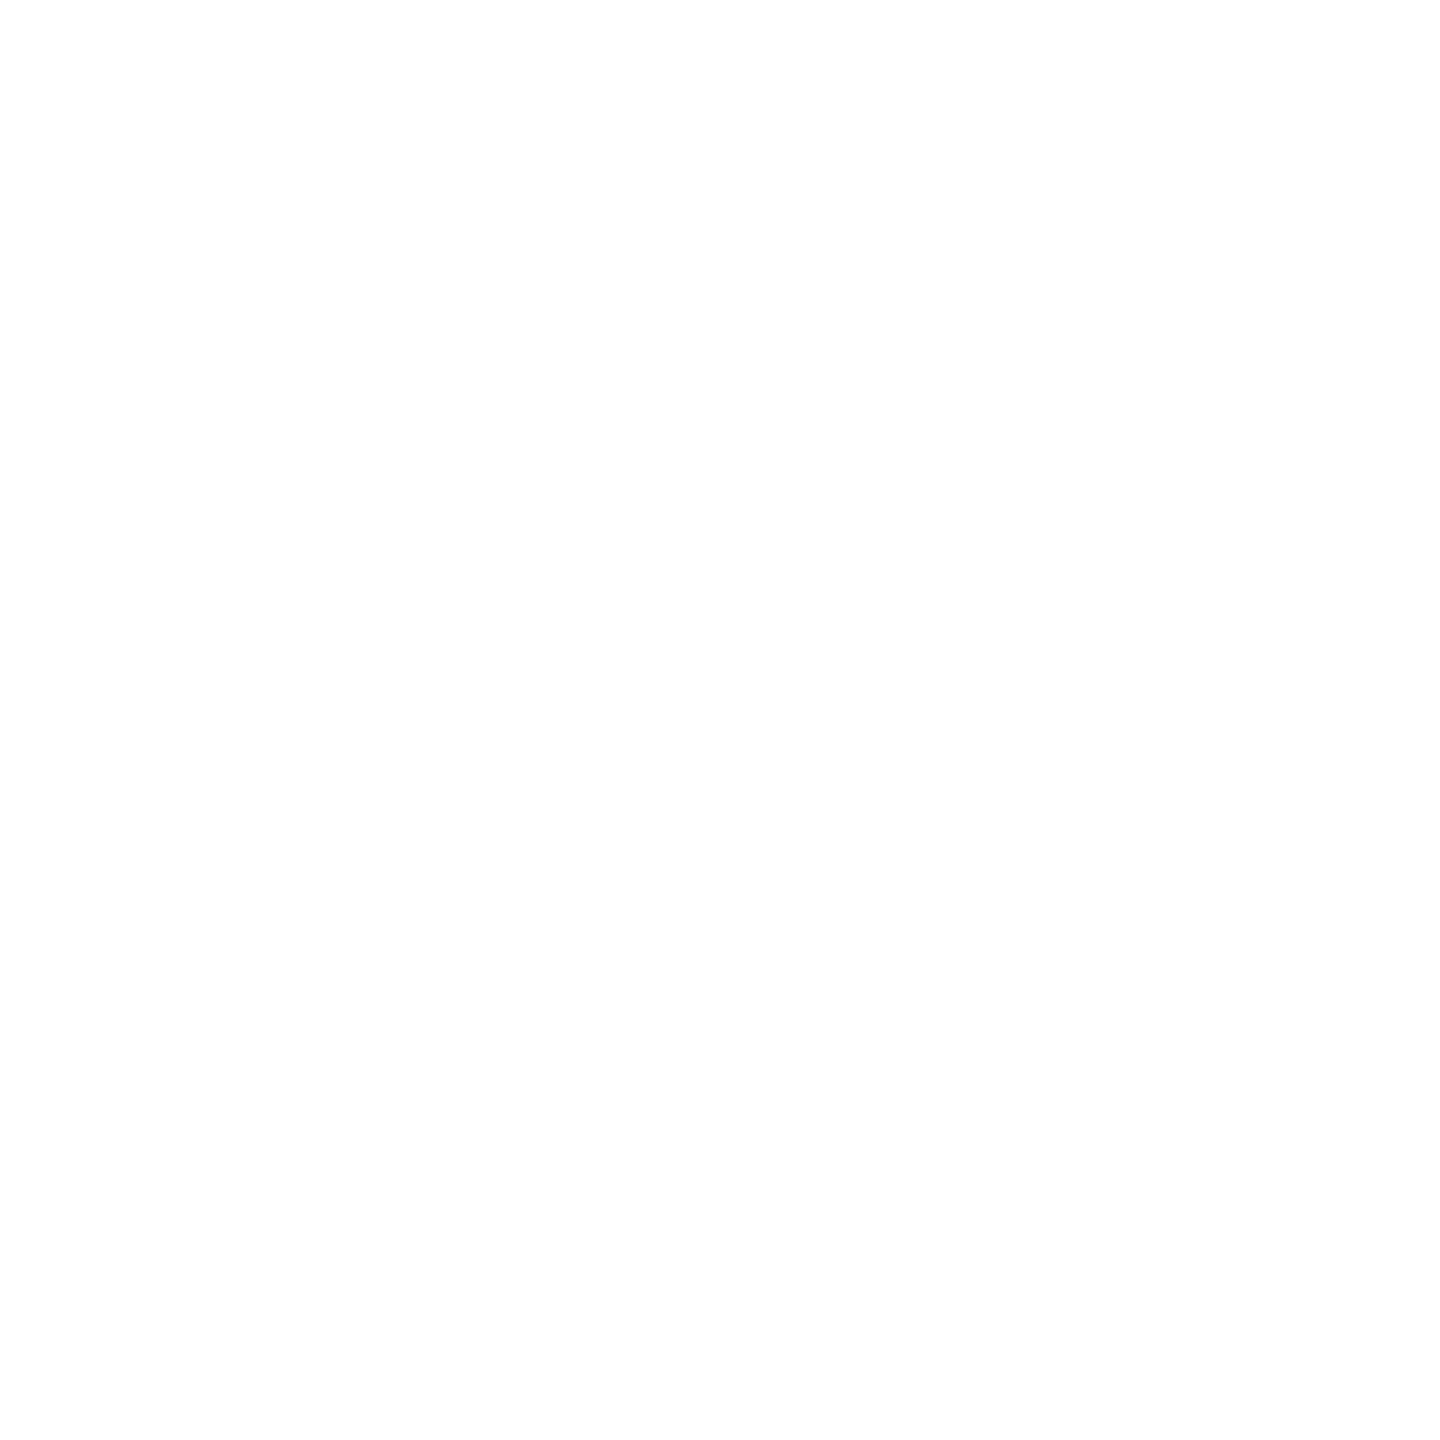

(array([15.50575041]), array([17.98]), 2)

In [23]:
#*********************************************************************************************
# Signal gaussian smoothing
sigma       = 0.01   # stdev
delta       = 2      # range = delta*stdev
# Delay
delta_delay = 10      # range of evaluated delays = [dt - delta_delay ; dt + delta_delay] [s]
step_delay  = 0.05   # step of evaluated delays [s]
# Time
start_time  = 30     # scanning signal starting time [s]
stop_time   = 45     # scanning signal stopping time [s]
step_time   = 0.005  # scanning signal step time [s]

vec1 = np.array([d.n for d in err_w_start_1])
vec2 = np.array([d.n for d in err_w_start_2])

signal1 = sig1_r
signal2 = sig2_r
#*********************************************************************************************

delay_gauss, delay_spectra, d2 = delay(sigma, delta, delta_delay, step_delay, start_time, stop_time, step_time,
                                       vec1, vec2, signal1, signal2,
                                       min_cut_idx=3000, max_cut_idx = 4500)

delay_gauss, delay_spectra, d2

### Manually check the delay

In [84]:
def align(delay):
    
    delay_idx = int(delay*100)
    
    fig, ax1 = plt.subplots(figsize=(9,6))
    
    ax1.plot(t, sig1_r, color='blue', alpha=0.3)
    
    ax2 = ax1.twinx()
    
    ax2.plot(t[:-delay_idx], sig2_r[delay_idx:], color='red', alpha=0.3)
    

def align_space(delay):
    delay_idx = int(delay*100)
    
    fig, ax1 = plt.subplots(figsize=(9,6))
    
    ax1.plot(t*50/delay, sig1_r, color='blue', alpha=0.3)
    
    ax2 = ax1.twinx()
    
    ax2.plot(t[:-delay_idx]*50/delay, sig2_r[delay_idx:], color='red', alpha=0.3)
    
    ax1.set_xlabel('position [mm]')

In [25]:
delay_gauss, delay_spectra, d2

(array([15.50575041]), array([17.98]), 2)

<IPython.core.display.Javascript object>


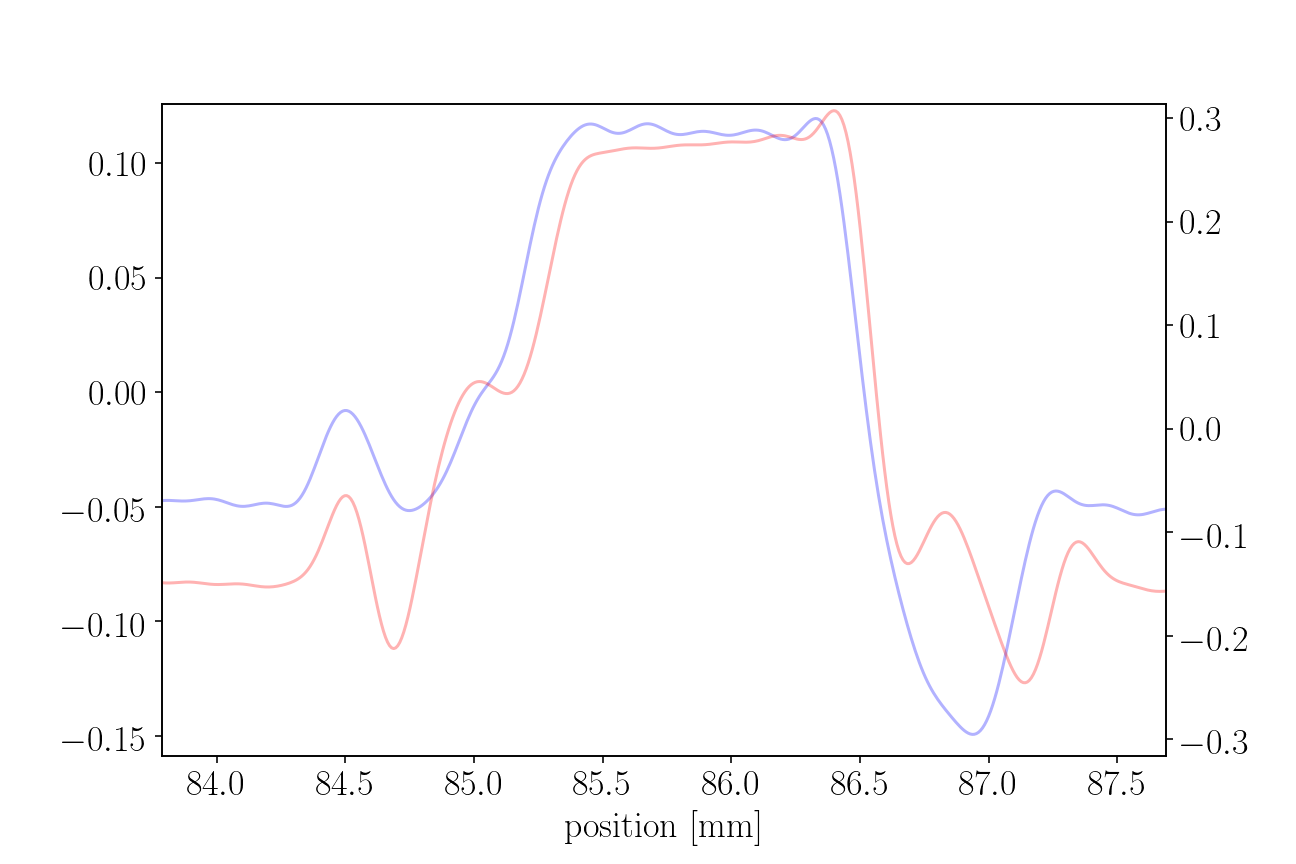

In [86]:
%matplotlib notebook
%matplotlib notebook

align_space(63.15)

## Adjust drops according to delay

In [27]:
#decide whether to use calculated d2 or to set it by hand
#d2 = 2
def adjust_drops(d1,d2, drop_edges_1, drop_edges_2):
    
    drop_edges_1 = [d[d1:] for d in drop_edges_1]
    drop_edges_2 = [d[d1 + d2:] for d in drop_edges_2]
    
    len2 = len(drop_edges_2[0])
    drop_edges_1 = [d[:len2] for d in drop_edges_1]
    
    return drop_edges_1, drop_edges_2

In [28]:
#THIS FUNCTION MODIFIES drop_start and drop_end s arrays

d1 = 0          #d1>0 to discard some initial drops that are present in both signals
#d2 = 2
if to_adjust:
    drop_edges_1,drop_edges_2 = adjust_drops(d1,d2, drop_edges_1, drop_edges_2)

    err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1 = drop_edges_1
    err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2 = drop_edges_2
    
    to_adjust = False

## Define variables of interest


Arrays  contain wide in first element, narrow in second element

In [29]:
#mid point (in seconds)
mid_1 = [0.5*(err_w_start_1+err_w_end_1),0.5*(err_n_start_1+err_n_end_1)]
mid_2 = [0.5*(err_w_start_2+err_w_end_2),0.5*(err_n_start_2+err_n_end_2)]

#drops distances in the same channel
distance_1 = [- err_w_end_1[:-1] + err_w_start_1[1:], - err_n_end_1[:-1] + err_n_start_1[1:]]
distance_2 = [- err_w_end_2[:-1] + err_w_start_2[1:], - err_n_end_2[:-1] + err_n_start_2[1:]]

#temporal size
size_1 = [err_w_end_1 - err_w_start_1,err_n_end_1 - err_n_start_1]
size_2 = [err_w_end_2 - err_w_start_2, err_n_end_2 - err_n_start_2]

dt_mid = [mid_2[0] - mid_1[0], mid_2[1] - mid_1[1]]
v_mid = [50/dt_mid[0],50/dt_mid[1]]

period_1 = [mid_1[0][1:]-mid_1[0][:-1],mid_1[1][1:]-mid_1[1][:-1]]
period_2 = [mid_2[0][1:]-mid_2[0][:-1],mid_2[1][1:]-mid_2[1][:-1]]


# PLOTTING

Variables have wide version in first element, wide version in second element.
Use parameter which = 0 for wide, which = 1 for narrow

## Temporal distance between drops in the same signal 

In [30]:
def time_dist(bins, distance_1, distance_2, which=0):
    
    #reload(uplt)
    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(3,5)

    ax_joint = fig.add_subplot(gs[:,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[:,3])
    ax_marg_y_2 = fig.add_subplot(gs[:,4])

    uplt.plot(distance_1[which], ax = ax_joint, label='sig1')
    uplt.plot(distance_2[which], ax = ax_joint, color='green', label='sig2')

    k1=uplt.ExtendedKDE(distance_1[which]) 
    ylim=ax_joint.get_ylim()
#     k1(np.linspace(ylim[0],ylim[1],bins))
#     k1.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_1, switch_xy=True)

    k2=uplt.ExtendedKDE(distance_2[which]) 
    ylim=ax_joint.get_ylim()
#     k2(np.linspace(ylim[0],ylim[1],bins))
#     k2.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_2, switch_xy=True, color='green')

    #Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('distances [s]')

    ax_joint.legend(loc='best')
    plt.title('Temporal distance between drops in the same signal, as a function of drop id number',loc='right', pad=15)

    #kde fit

    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    fig.tight_layout()
    plt.show()
    
    dist1 = unc.ufloat(out1.params['g1_center'].value, out1.params['g1_center'].stderr)
    sigma_dist1 = unc.ufloat(out1.params['g1_sigma'].value, out1.params['g1_sigma'].stderr)
    dist2 = unc.ufloat(out2.params['g2_center'].value, out2.params['g2_center'].stderr)
    sigma_dist2 = unc.ufloat(out2.params['g2_sigma'].value, out2.params['g2_sigma'].stderr)
    


    return fig, dist1, sigma_dist1, dist2, sigma_dist2


<IPython.core.display.Javascript object>


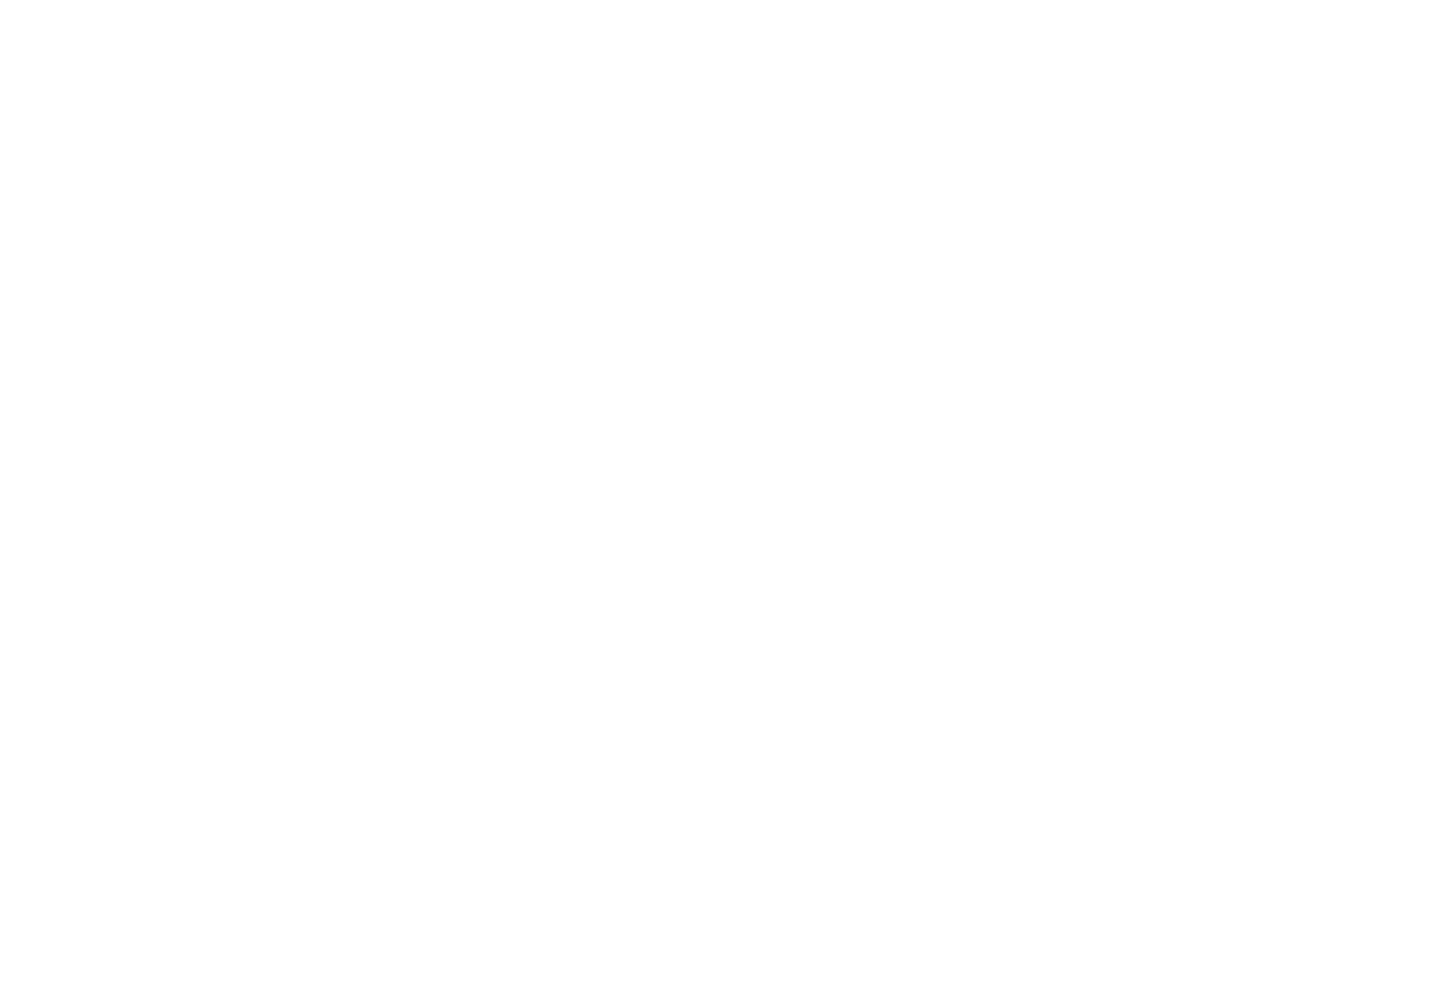

100%|██████████| 300/300 [00:05<00:00, 51.84it/s]
<ipython-input-30-2dc2d12915aa>:51: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [31]:
#*************
subname = 'timedist_wide'
bins    = 300
#*************

f1, dist1_w, sigma_dist1_w, dist2_w, sigma_dist2_w = time_dist(bins, distance_1, distance_2, which=0)

f1.savefig(f'{plot_dir}/{name}_{subname}.png')

<IPython.core.display.Javascript object>


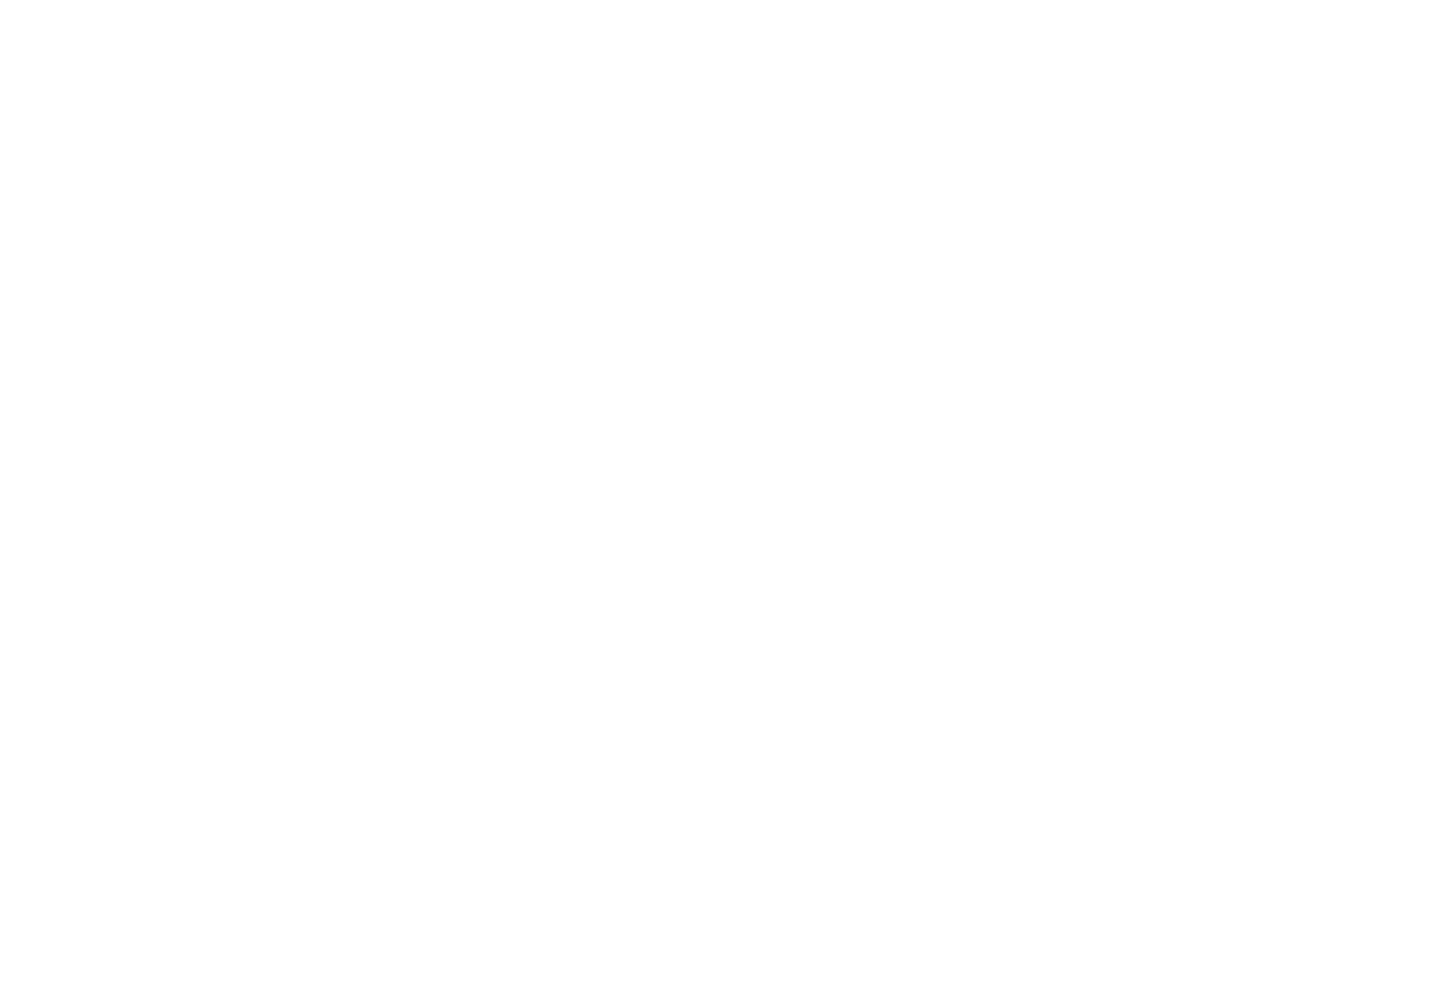

100%|██████████| 150/150 [00:02<00:00, 51.94it/s]
<ipython-input-30-2dc2d12915aa>:51: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [32]:
#*************
subname = 'timedist_narrow'
bins    = 150
#*************

f2, dist1_n, sigma_dist1_n, dist2_n, sigma_dist2_n = time_dist(bins, distance_1, distance_2, which=1)

f2.savefig(f'{plot_dir}/{name}_{subname}.png')

## Temporal size 

In [33]:
def time_size(bins, size_1, size_2, which=0):
    
    #reload(uplt)
    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(3,5)

    ax_joint = fig.add_subplot(gs[:,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[:,3])
    ax_marg_y_2 = fig.add_subplot(gs[:,4])

    uplt.plot(size_1[which], ax = ax_joint, label='sig1')
    uplt.plot(size_2[which], ax = ax_joint, color='green', label='sig2')

    k1=uplt.ExtendedKDE(size_1[which]) 
    ylim=ax_joint.get_ylim()
#     k1(np.linspace(ylim[0],ylim[1],bins))
#     k1.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_1, switch_xy=True)

    k2=uplt.ExtendedKDE(size_2[which]) 
    ylim=ax_joint.get_ylim()
#     k2(np.linspace(ylim[0],ylim[1],bins))
#     k2.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_2, switch_xy=True, color='green')

    #Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('sizes [s]')

    ax_joint.legend(loc='best')
    plt.title('Temporal size of drops in each signal, as a function of drop id number',loc='right', pad=15)

    #kde fit

    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    fig.tight_layout()
    plt.show()
    
    t_size1 = unc.ufloat(out1.params['g1_center'].value, out1.params['g1_center'].stderr)
    sigma_t_size1 = unc.ufloat(out1.params['g1_sigma'].value, out1.params['g1_sigma'].stderr)
    t_size2 = unc.ufloat(out2.params['g2_center'].value, out2.params['g2_center'].stderr)
    sigma_t_size2 = unc.ufloat(out2.params['g2_sigma'].value, out2.params['g2_sigma'].stderr)


    return fig, t_size1, sigma_t_size1, t_size2, sigma_t_size2 


<IPython.core.display.Javascript object>


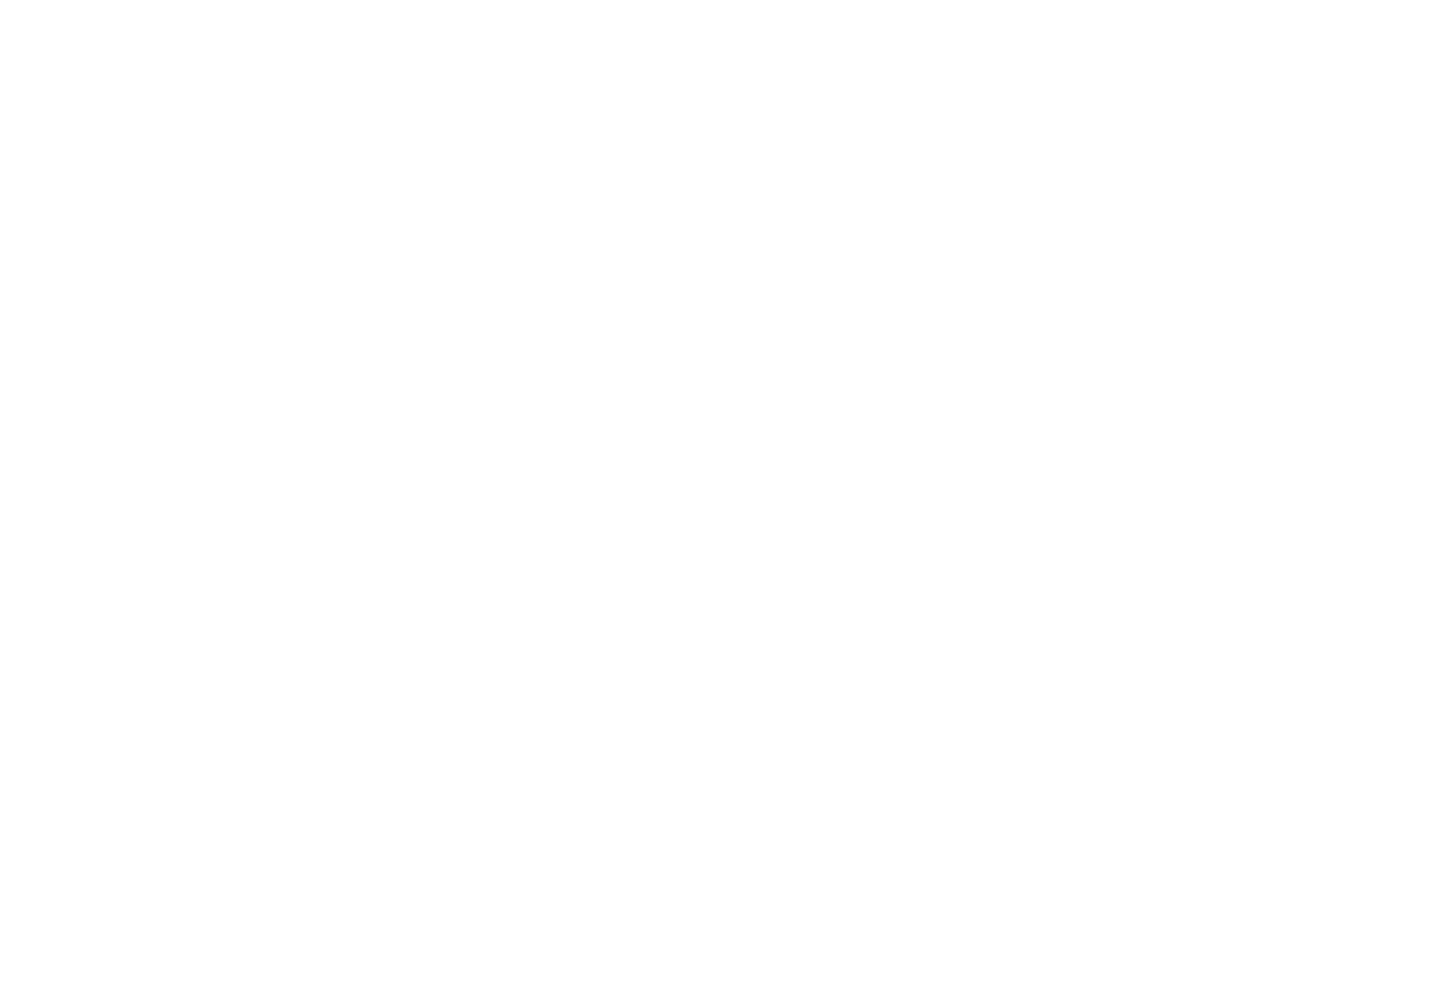

100%|██████████| 70/70 [00:01<00:00, 47.73it/s]
<ipython-input-33-511f34cbce6c>:51: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [34]:
#*************
subname = 'timesize_wide'
bins    = 70
#*************

f3, t_size1_w, sigma_t_size1_w, t_size2_w, sigma_t_size2_w = time_size(bins, size_1, size_2, which=0)

f3.savefig(f'{plot_dir}/{name}_{subname}.png')

<IPython.core.display.Javascript object>


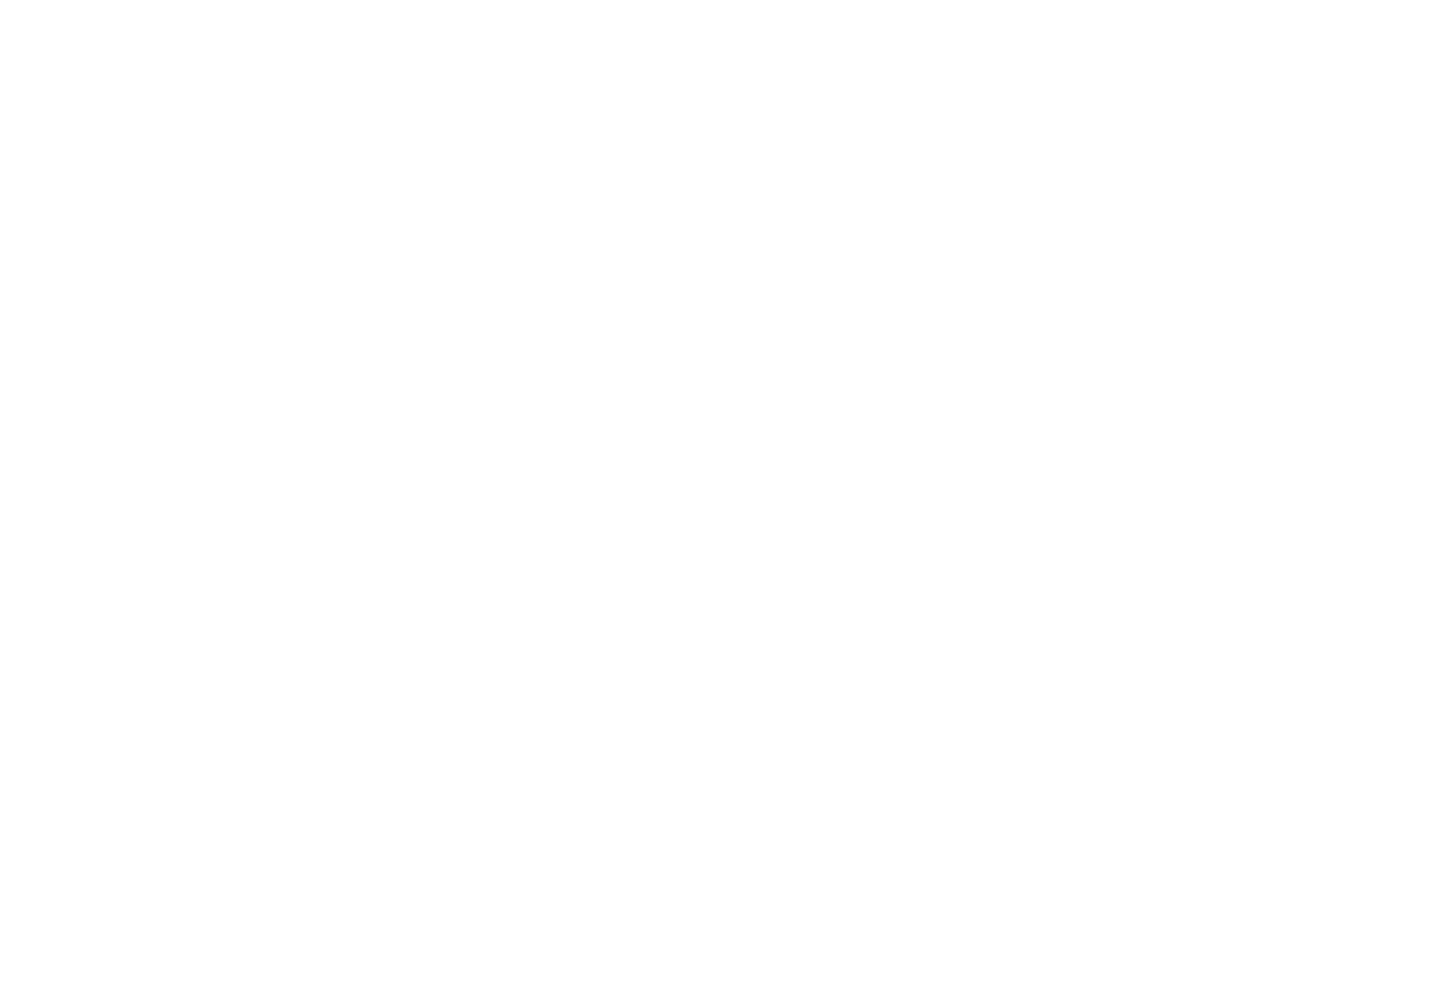

100%|██████████| 100/100 [00:02<00:00, 47.66it/s]
<ipython-input-33-511f34cbce6c>:51: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [35]:
#*************
subname = 'timesize_narrow'
bins    = 100
#*************

f4, t_size1_n, sigma_t_size1_n, t_size2_n, sigma_t_size2_n = time_size(bins, size_1, size_2, which=1)

f4.savefig(f'{plot_dir}/{name}_{subname}.png')

## Time separation between detectors and drop velocity

In [36]:
def dt_vel(bins,dt_mid,v_mid,which=0):
    
    fig = plt.figure(figsize=(10,7.5))

    gs = GridSpec(7,4)
    #first plot
    ax_joint = fig.add_subplot(gs[:3,0:3])
    ax_marg_y = fig.add_subplot(gs[:3,3])

    uplt.plot(dt_mid[which], ax = ax_joint, label='time interval')  
    
    k1=uplt.ExtendedKDE(dt_mid[which]) 
    ylim=ax_joint.get_ylim()
#     k1(np.linspace(ylim[0],ylim[1],bins))
#     k1.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y, switch_xy=True)

    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('detectors time interval [s]')

    plt.title('Temporal delay of drops in the detectors and drop velocity',loc='right', pad=15)

    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    #second plot
    ax1_joint = fig.add_subplot(gs[4:,0:3])
    ax1_marg_y = fig.add_subplot(gs[4:,3])

    uplt.plot(0.5*(mid_1[which]+mid_2[which]),v_mid[which], ax=ax1_joint, label='velocity', color='green')
    k2=uplt.ExtendedKDE(v_mid[which]) 
    ylim=ax1_joint.get_ylim()
#     k2(np.linspace(ylim[0],ylim[1],bins))
#     k2.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax1_marg_y, switch_xy=True, color='green')


    ax1_joint.set_xlabel('time (drop equidistant from detectors) [s]')
    ax1_joint.set_ylabel('drops velocity [mm/s]')
    
   
    plt.setp(ax1_marg_y.get_yticklabels(), visible=False)
    
    #Turn off tick labels on marginals
    plt.setp(ax1_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

       
    fig.tight_layout()
    plt.show()

    
    return fig

<IPython.core.display.Javascript object>


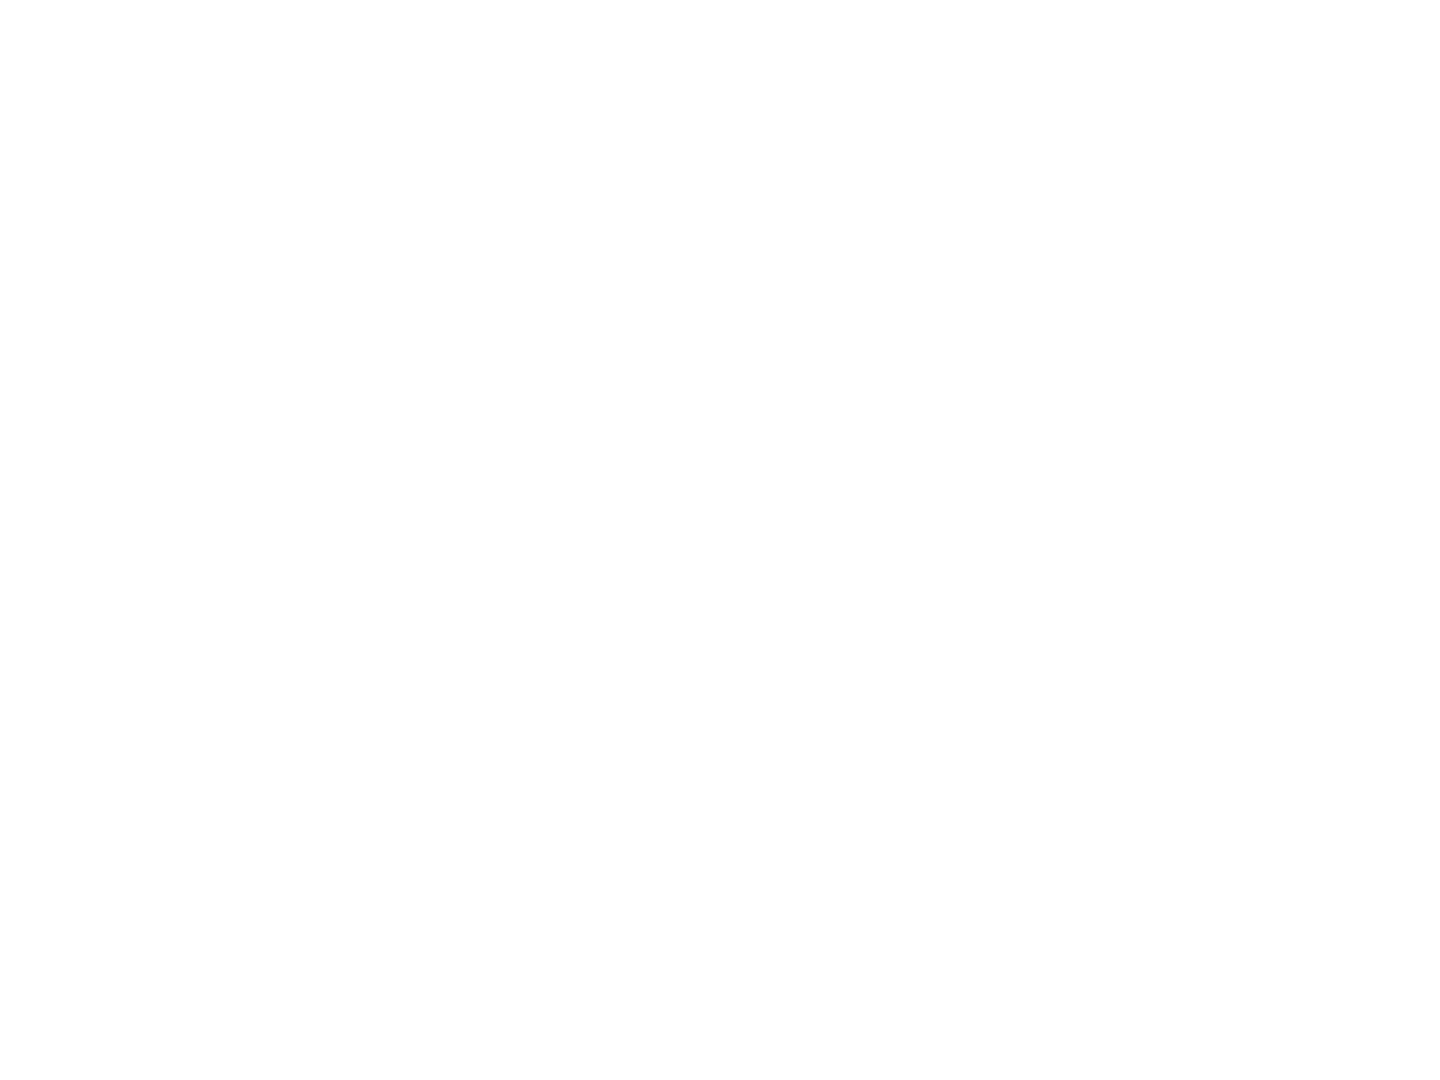

100%|██████████| 40/40 [00:00<00:00, 51.51it/s]
<ipython-input-36-0dc40a5c1aa6>:48: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [37]:
#************
subname = 'velocity_wide'
bins    = 40
#************
reload(uplt)
f5 = dt_vel(bins, dt_mid, v_mid,which=0)

f5.savefig(f'{plot_dir}/{name}_{subname}.png')

<IPython.core.display.Javascript object>


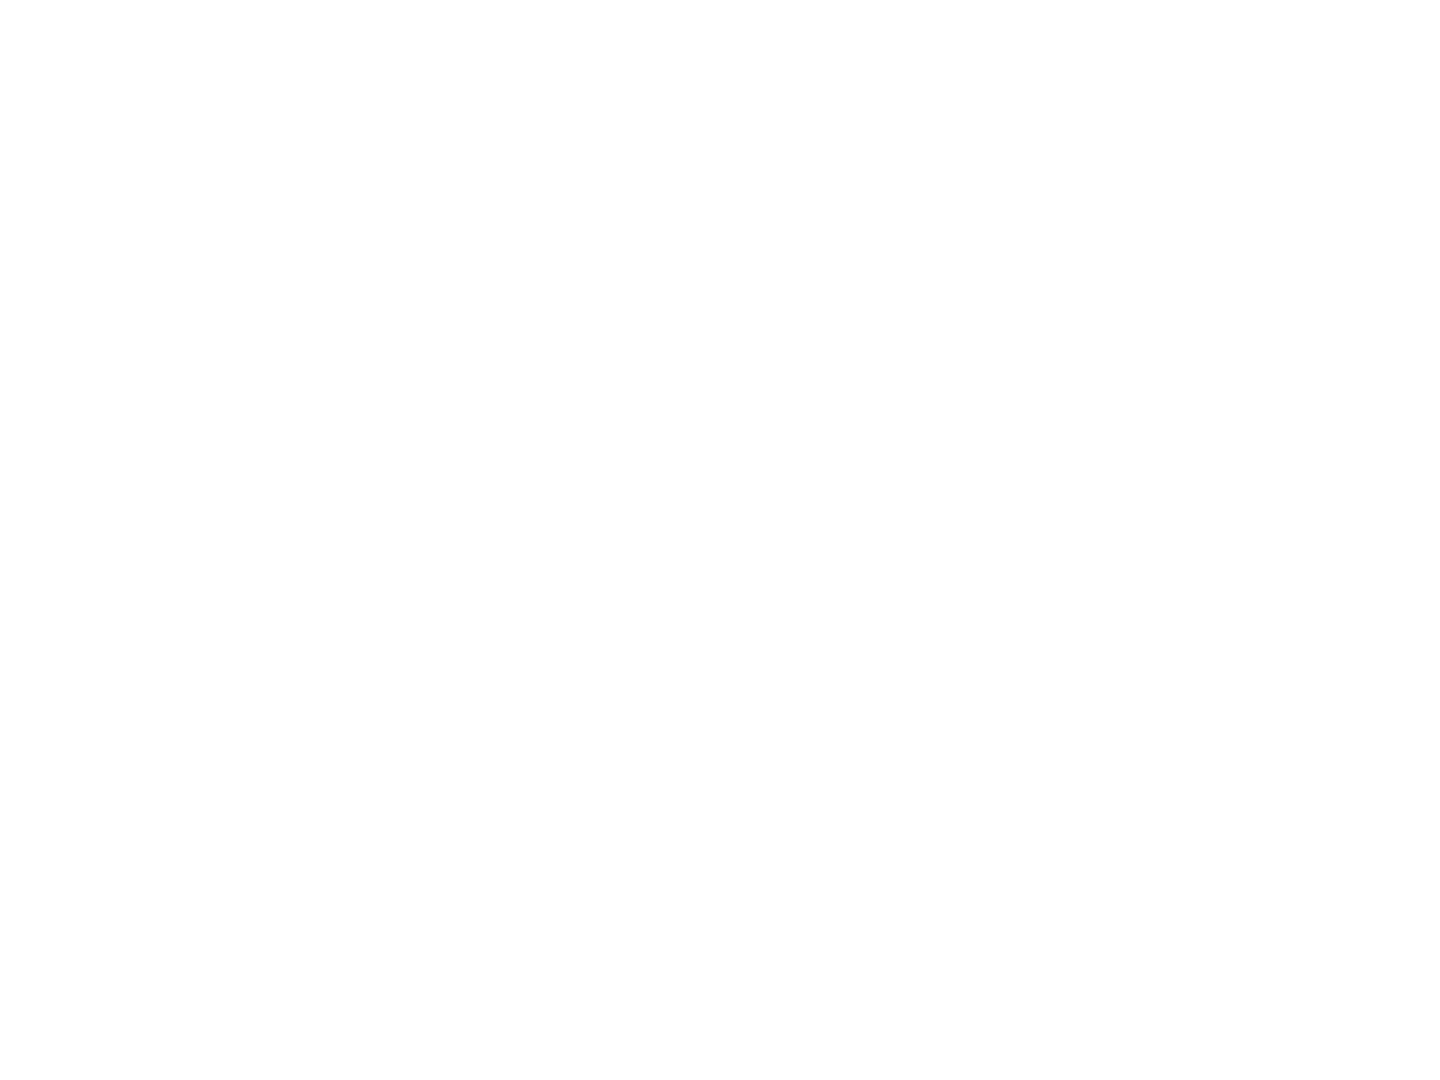

100%|██████████| 40/40 [00:00<00:00, 46.28it/s]
<ipython-input-36-0dc40a5c1aa6>:48: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [38]:
#************
subname = 'velocity_narrow'
bins    = 40
#************
reload(uplt)
f6 = dt_vel(bins, dt_mid, v_mid,which=1)

f6.savefig(f'{plot_dir}/{name}_{subname}.png')

## Spatial size

In [39]:
def space_size(bins, space_size_1, space_size_2, v_mid,which=0):
    
    reload(uplt)
    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(3,5)
    ax_joint = fig.add_subplot(gs[:,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[:,3])
    ax_marg_y_2 = fig.add_subplot(gs[:,4])

    uplt.plot(size_1[which]*v_mid[which], ax = ax_joint, label='sig1')
    uplt.plot(size_2[which]*v_mid[which], ax = ax_joint, color='green', label='sig2')

    k1=uplt.ExtendedKDE(size_1[which]*v_mid[which]) 
    ylim=ax_joint.get_ylim()
#     k1(np.linspace(ylim[0],ylim[1],bins))
#     k1.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_1, switch_xy=True)

    k2=uplt.ExtendedKDE(size_2[which]*v_mid[which]) 
    ylim=ax_joint.get_ylim()
#     k2(np.linspace(ylim[0],ylim[1],bins))
#     k2.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_2, switch_xy=True, color='green')

    #Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('sizes [s]')

    ax_joint.legend(loc='best')
    plt.title('Spatial size of drops in each signal, as a function of drop id number',loc='right', pad=15)

    #kde fit

    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    fig.tight_layout()
    plt.show()

    size1 = unc.ufloat(out1.params['g1_center'].value, out1.params['g1_center'].stderr)
    sigma_size1 = unc.ufloat(out1.params['g1_sigma'].value, out1.params['g1_sigma'].stderr)
    size2 = unc.ufloat(out2.params['g2_center'].value, out2.params['g2_center'].stderr)
    sigma_size2 = unc.ufloat(out2.params['g2_sigma'].value, out2.params['g2_sigma'].stderr)
    
    return fig, size1, sigma_size1, size2, sigma_size2

<IPython.core.display.Javascript object>


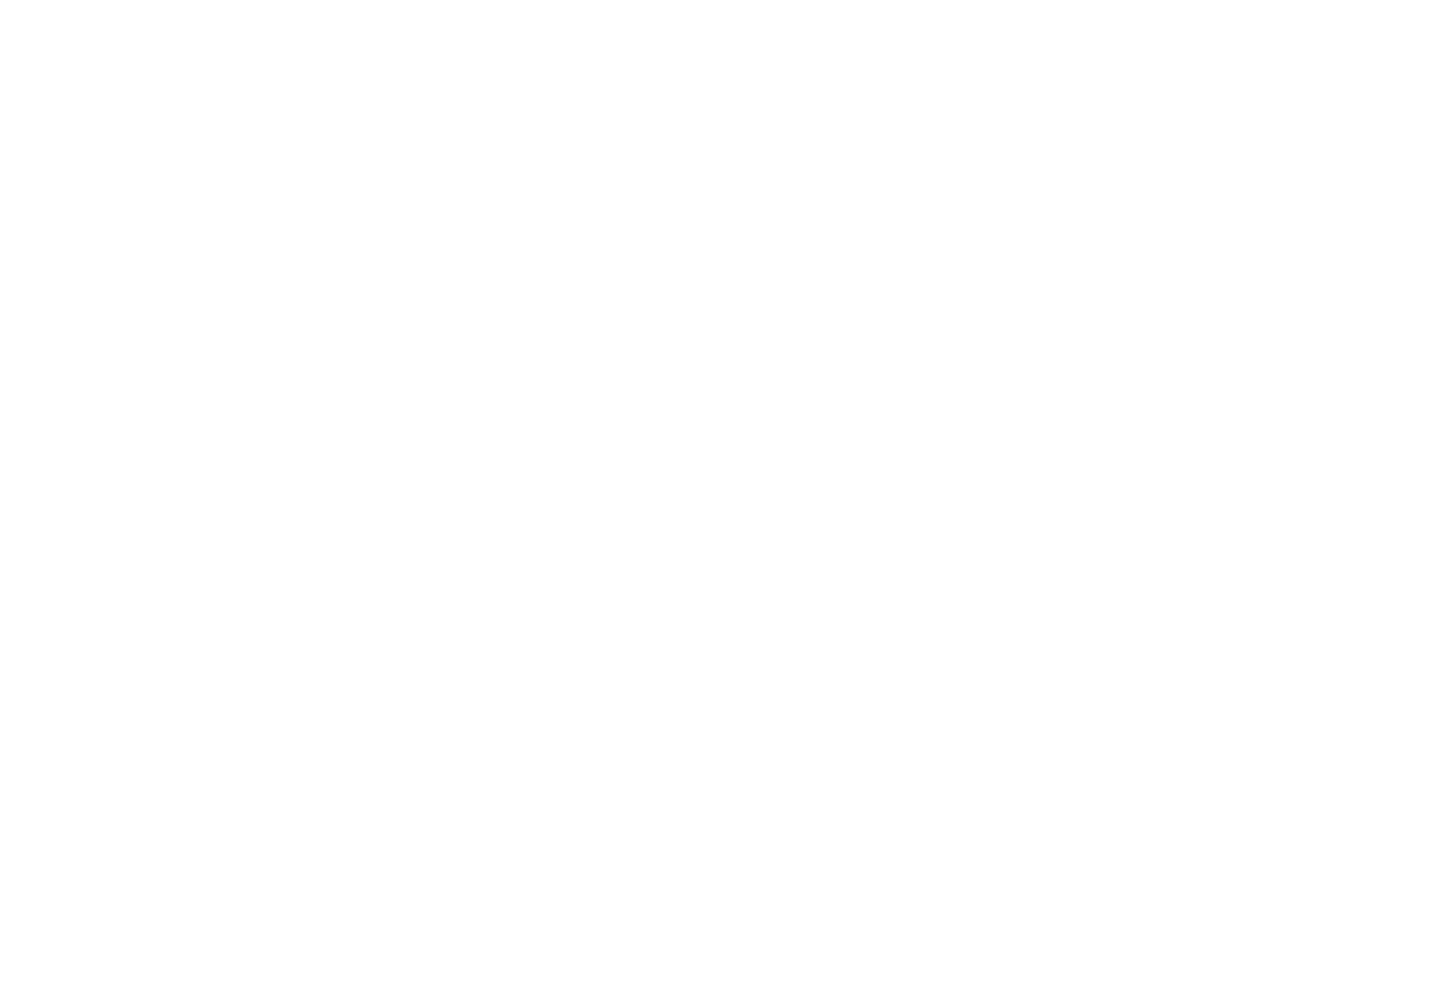

100%|██████████| 120/120 [00:02<00:00, 48.61it/s]
<ipython-input-39-12e443fea9b7>:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [40]:
#*****************************
subname = 'spatialsize_wide'
bins    = 120
#*****************************

f7, size1_w, sigma_size1_w, size2_w, sigma_size2_w  = space_size(bins, size_1, size_2, v_mid, which=0)

f7.savefig(f'{plot_dir}/{name}_{subname}.png')

<IPython.core.display.Javascript object>


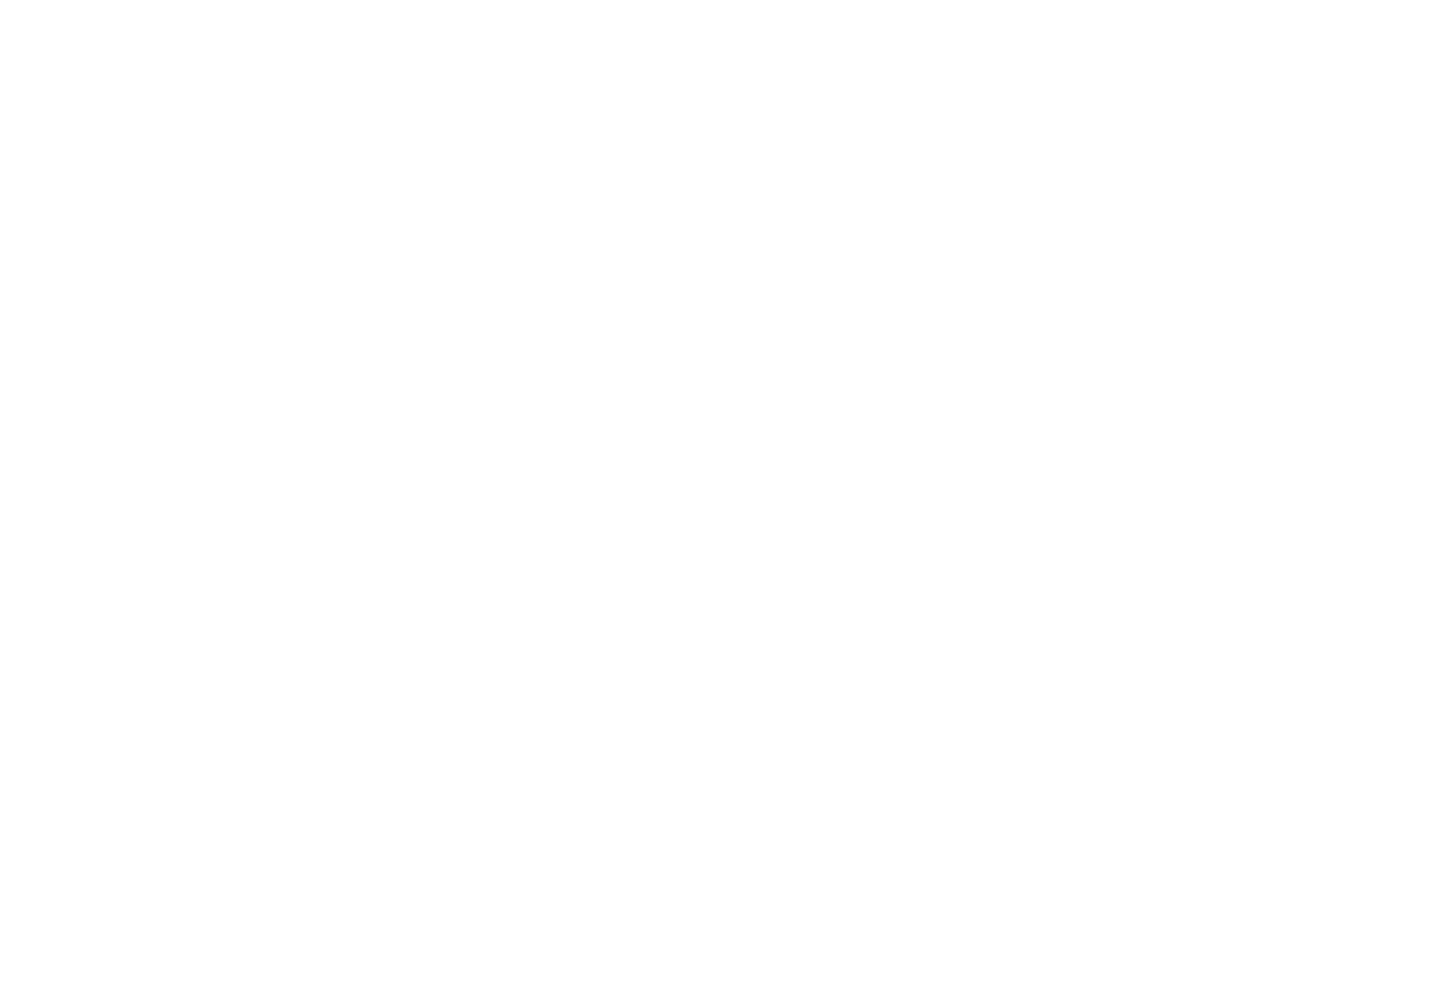

100%|██████████| 80/80 [00:01<00:00, 50.35it/s]
<ipython-input-39-12e443fea9b7>:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [41]:
#*****************************
subname = 'spatialsize_narrow'
bins    = 80
#*****************************

f8, size1_n, sigma_size1_n, size2_n, sigma_size2_n  = space_size(bins, size_1, size_2, v_mid, which=1)

f8.savefig(f'{plot_dir}/{name}_{subname}.png')

## Period between adiacent drops

In [42]:
def period(bins, period_1, period_2, which=0):
    
    reload(uplt)
    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(3,5)
    ax_joint = fig.add_subplot(gs[:,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[:,3])
    ax_marg_y_2 = fig.add_subplot(gs[:,4])

    uplt.plot(period_1[which], ax = ax_joint, label='sig1')
    uplt.plot(period_2[which], ax = ax_joint, color='green', label='sig2')

    k1=uplt.ExtendedKDE(period_1[which]) 
    ylim=ax_joint.get_ylim()
#     k1(np.linspace(ylim[0],ylim[1],bins))
#     k1.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_1, switch_xy=True)

    k2=uplt.ExtendedKDE(period_2[which]) 
    ylim=ax_joint.get_ylim()
#     k2(np.linspace(ylim[0],ylim[1],bins))
#     k2.evaluate(np.linspace(ylim[0],ylim[1],bins))
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_2, switch_xy=True, color='green')

    #Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('period [s]')

    ax_joint.legend(loc='best')
    plt.title('Drops period in each signal, as a function of drop id number',loc='right', pad=15)

    #kde fit

    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    fig.tight_layout()
    plt.show()

    period1 = unc.ufloat(out1.params['g1_center'].value, out1.params['g1_center'].stderr)
    sigma_period1 = unc.ufloat(out1.params['g1_sigma'].value, out1.params['g1_sigma'].stderr)
    period2 = unc.ufloat(out2.params['g2_center'].value, out2.params['g2_center'].stderr)
    sigma_period2 = unc.ufloat(out2.params['g2_sigma'].value, out2.params['g2_sigma'].stderr)
    
    return fig, period1, sigma_period1, period2, sigma_period2

100%|██████████| 80/80 [00:01<00:00, 48.30it/s]
<ipython-input-42-8fdad1adb3be>:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


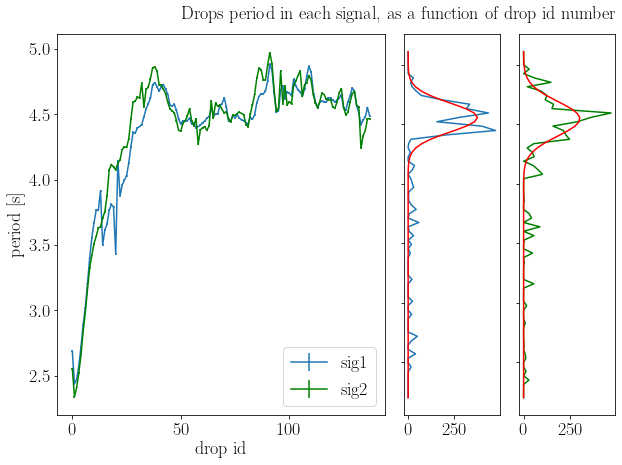

In [43]:
%matplotlib inline
#*****************************
subname = 'period_wide'
bins    = 80
#*****************************
f9, period1_w, sigma_period1_w, period2_w, sigma_period2_w = period(bins, period_1, period_2, which=0)

f9.savefig(f'{plot_dir}/{name}_{subname}.png')

100%|██████████| 80/80 [00:01<00:00, 50.97it/s]
<ipython-input-42-8fdad1adb3be>:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


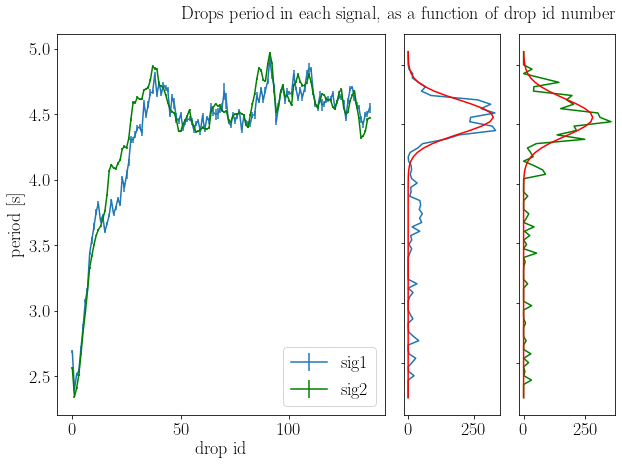

In [44]:
#*****************************
subname = 'period_narrow'
bins    = 80
#*****************************

f10, period1_n, sigma_period1_n, period2_n, sigma_period2_n = period(bins, period_1, period_2, which=1)

f10.savefig(f'{plot_dir}/{name}_{subname}.png')

In [52]:
def meniscus(bins, drop_edges_1, drop_edges_2):
    
    reload(uplt)
    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(10,5)
    ax_joint = fig.add_subplot(gs[:4,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[:4,3])
    ax_marg_y_2 = fig.add_subplot(gs[:4,4])
    ax1_joint = fig.add_subplot(gs[6:,0:3])
    ax1_marg_y_1 = fig.add_subplot(gs[6:,3])
    ax1_marg_y_2 = fig.add_subplot(gs[6:,4])

    uplt.plot(drop_edges_1[1]-drop_edges_1[0], ax = ax_joint, label='start meniscus')
    uplt.plot(drop_edges_1[3]-drop_edges_1[2], ax = ax_joint, color='green', label='end meniscus')
    uplt.plot(drop_edges_2[1]-drop_edges_2[0], ax = ax1_joint, label='start meniscus')
    uplt.plot(drop_edges_2[3]-drop_edges_2[2], ax = ax1_joint, color='green', label='end meniscus')

    k1=uplt.ExtendedKDE(drop_edges_1[1]-drop_edges_1[0]) 
    ylim=ax_joint.get_ylim()
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_1, switch_xy=True)

    k2=uplt.ExtendedKDE(drop_edges_1[3]-drop_edges_1[2]) 
    ylim=ax_joint.get_ylim()
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_2, switch_xy=True, color='green')
    
    h1=uplt.ExtendedKDE(drop_edges_2[1]-drop_edges_2[0]) 
    ylim1=ax1_joint.get_ylim()
    b1,fr1 = h1.plot(np.linspace(ylim1[0],ylim1[1],bins), ax = ax1_marg_y_1, switch_xy=True)

    h2=uplt.ExtendedKDE(drop_edges_2[3]-drop_edges_2[2]) 
    ylim1=ax1_joint.get_ylim()
    b2,fr2 = h2.plot(np.linspace(ylim1[0],ylim1[1],bins), ax = ax1_marg_y_2, switch_xy=True, color='green')

    #Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)
    plt.setp(ax1_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax1_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('meniscus size [mm]')
    ax1_joint.set_xlabel('drop id')
    ax1_joint.set_ylabel('meniscus size [mm]')

    ax_joint.legend(loc='best')
    ax_joint.set_title('Drop meniscus size in first signal',loc='right', pad=15)
    ax1_joint.legend(loc='best')
    ax1_joint.set_title('Drop meniscus size in second signal',loc='right', pad=15)

    #kde fit

    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')
    
    mod3 = GaussianModel(prefix='g3_')
    pars3 = mod3.guess(fr1, x=b1)
    out3 = mod3.fit(fr1, pars3, x=b1)
    ax1_marg_y_1.plot(out3.best_fit, b1, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    mod4 = GaussianModel(prefix='g4_')
    pars4 = mod4.guess(fr2, x=b2)
    out4 = mod4.fit(fr2, pars4, x=b2)
    ax1_marg_y_2.plot(out4.best_fit, b2, 'r-', label='best fit')
    #ax_marg_y_1.legend(loc='best')

    fig.tight_layout()
    plt.show()

    m1 = unc.ufloat(out1.params['g1_center'].value, out1.params['g1_center'].stderr)
    sigma_m1 = unc.ufloat(out1.params['g1_sigma'].value, out1.params['g1_sigma'].stderr)
    m2 = unc.ufloat(out2.params['g2_center'].value, out2.params['g2_center'].stderr)
    sigma_m2 = unc.ufloat(out2.params['g2_sigma'].value, out2.params['g2_sigma'].stderr)
    m3 = unc.ufloat(out3.params['g3_center'].value, out3.params['g3_center'].stderr)
    sigma_m3 = unc.ufloat(out3.params['g3_sigma'].value, out3.params['g3_sigma'].stderr)
    m4 = unc.ufloat(out4.params['g4_center'].value, out4.params['g4_center'].stderr)
    sigma_m4 = unc.ufloat(out4.params['g4_sigma'].value, out4.params['g4_sigma'].stderr)
    
    
    return fig, m1, sigma_m1, m2, sigma_m2, m3, sigma_m3, m4, sigma_m4

<IPython.core.display.Javascript object>


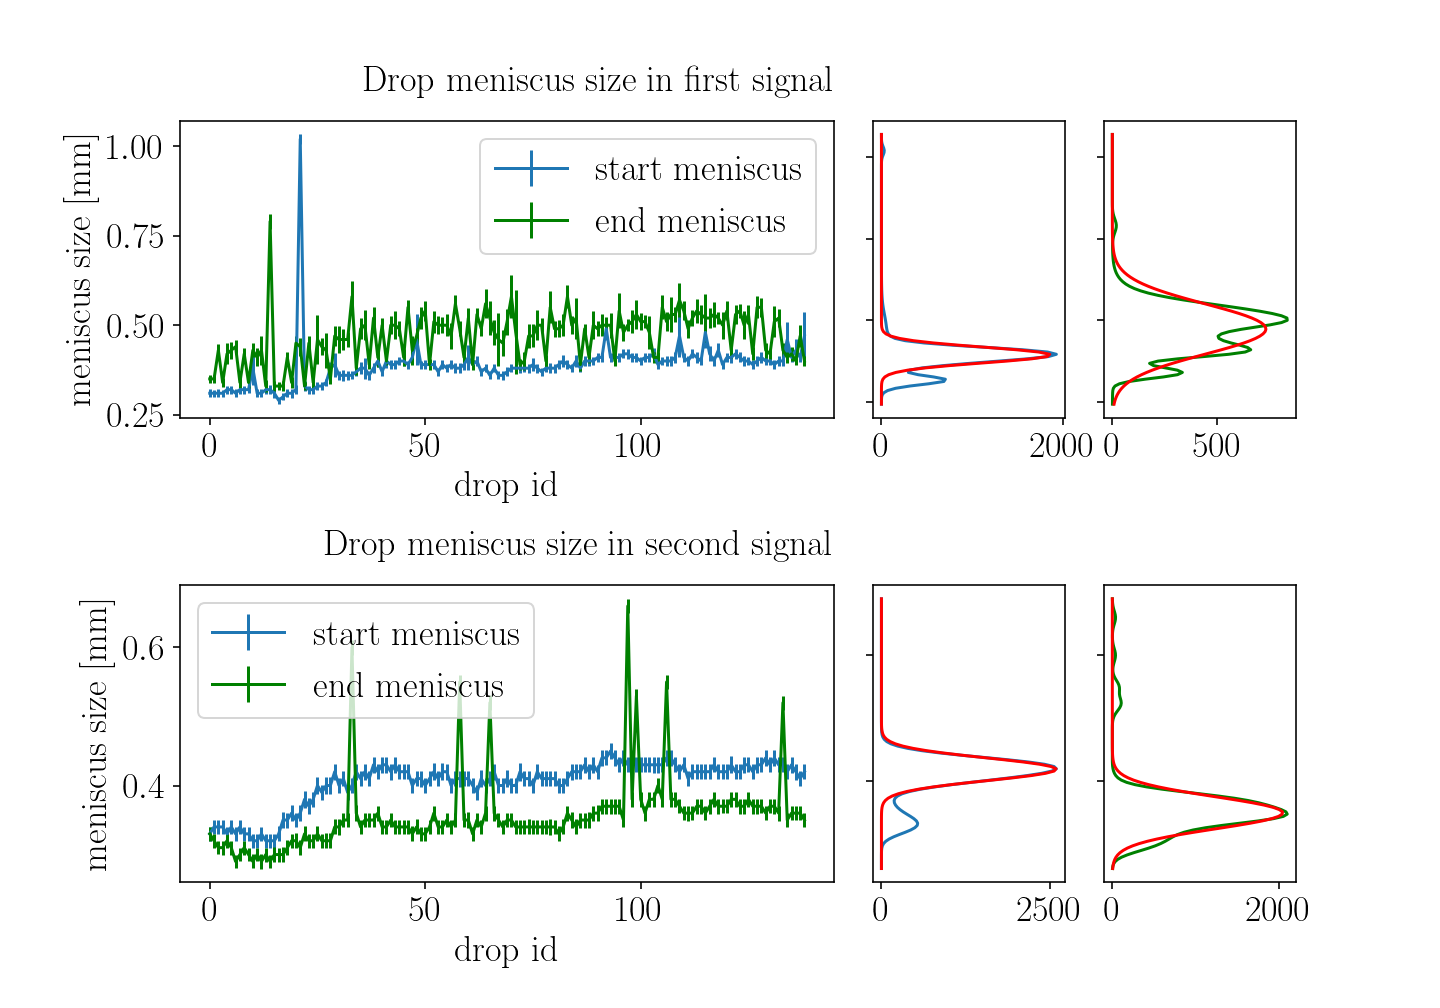

100%|██████████| 120/120 [00:02<00:00, 48.05it/s]
<ipython-input-52-e9bb428a4a9d>:77: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


In [54]:
%matplotlib notebook

#*****************************
subname = 'meniscus'
bins    = 120
#*****************************

f11, m1, sigma_m1, m2, sigma_m2,m3, sigma_m3, m4, sigma_m4=meniscus(bins, drop_edges_1, drop_edges_2)
f11.savefig(f'{plot_dir}/{name}_{subname}.png')

## Save fit parameters to file

In [47]:
### TO MODIFY PROBABLY

In [55]:
a='parameters'
with open(f'{plot_dir}/{name}_{a}.csv', mode='w', newline ='') as file:
    writer = csv.writer(file, delimiter='	', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    s = ['file containing parameters from fit: center_1, sigma_1, center_2, sigma_2']
    writer.writerow(s)
    a = ['spatial size wide (mm)',size1_w.n, size1_w.s, sigma_size1_w.n, sigma_size1_w.s, size2_w.n, size2_w.s, sigma_size2_w.n, sigma_size2_w.s]
    writer.writerow(a)
    a1 = ['spatial size narrow (mm)',size1_n.n, size1_n.s, sigma_size1_n.n, sigma_size1_n.s, size2_n.n, size2_n.s, sigma_size2_n.n, sigma_size2_n.s]
    writer.writerow(a1)
    b = ['temporal size wide (s)',t_size1_w.n, t_size1_w.s, sigma_t_size1_w.n, sigma_t_size1_w.s, t_size2_w.n, t_size2_w.s, sigma_t_size2_w.n, sigma_t_size2_w.s]
    writer.writerow(b)
    b1 = ['temporal size narrow (s)',t_size1_n.n, t_size1_n.s, sigma_t_size1_n.n, sigma_t_size1_n.s, t_size2_n.n, t_size2_n.s, sigma_t_size2_n.n, sigma_t_size2_n.s]
    writer.writerow(b1)
    c = ['temporal distance wide (mm)',dist1_w.n, dist1_w.s, sigma_dist1_w.n, sigma_dist1_w.s, dist2_w.n, dist2_w.s, sigma_dist2_w.n, sigma_dist2_w.s]
    writer.writerow(c)
    c1 = c1 = ['temporal distance narrow (mm)',dist1_n.n, dist1_n.s, sigma_dist1_n.n, sigma_dist1_n.s, dist2_n.n, dist2_n.s, sigma_dist2_n.n, sigma_dist2_n.s]
    writer.writerow(c1)
    d = ['period wide (s)',period1_w.n, period1_w.s, sigma_period1_w.n, sigma_period1_w.s, period2_w.n, period2_w.s, sigma_period2_w.n, sigma_period2_w.s]
    writer.writerow(d)
    d1 = ['period narrow (s)',period1_n.n, period1_n.s, sigma_period1_n.n, sigma_period1_n.s, period2_n.n, period2_n.s, sigma_period2_n.n, sigma_period2_n.s]
    writer.writerow(d1)
    e =['meniscus start, end, sig1', m1.n, m1.s, sigma_m1.n, sigma_m1.s, m2.n, m2.s, sigma_m2.n, sigma_m2.s]
    writer.writerow(e)
    e1 = ['meniscus start, end, sig2', m3.n, m3.s, sigma_m3.n, sigma_m3.s, m4.n, m4.s, sigma_m4.n, sigma_m4.s]
    writer.writerow(e1)
    f = ['mean velocity wide, narrow (mm/s)',np.mean(v_mid[0]).n, np.mean(v_mid[0]).s, np.mean(v_mid[1]).n, np.mean(v_mid[1]).s]
    writer.writerow(f)
    